Import Libraries

In [1]:
import pandas as pd
import numpy as np
import glob
import PIL
from PIL import Image
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
random.seed(42)
tf.random.set_seed(42)
np.random.seed(42)

Load the photos with size 50 X 50

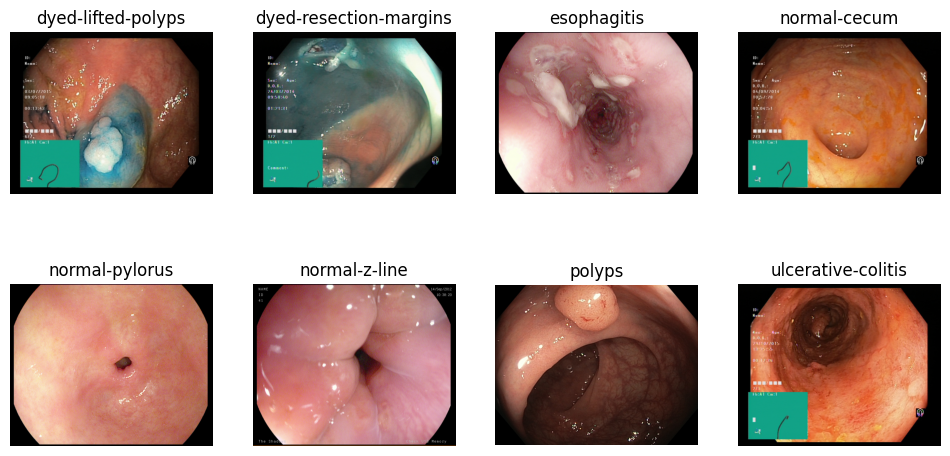

In [2]:
path = r'D:\Semester 2\Data Analytics and Visualisation\Assignment 2\Dataset\*' #The path of the dataset with the 8 directories
def dict_df(path : str, size = 50):
    d = {} #A dictionary in which we will pass a list of the image converted to array and the target. The key will be a number from 0 to 7999 in ascending order
    count = 0 #A counter for the key of the dictionary
    _, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()
    m = 0
    for i in glob.glob(path): #For i in the path, the glob function will return a list with paths for each dictionay that the images are found in
        #print(i)
        verb = 0
        for j in glob.glob(i + "/*.jpg"): #For j in the list that the glob function returns. The list will contain the files in the dictionary with path i that have an extension jpg
            im = Image.open(j) #We open each image
            if verb==0:
                axes[m].imshow(im)
                axes[m].axis('off')
                axes[m].set_title(i.split("\\")[-1])
                verb = 1
            im = im.resize((size,size)) #We resize it
            arr = np.asarray(im) #We convert it to an array
            d[count] = [arr, i.split("\\")[-1]] #We pass a list into the dictionary. The will contain the image (converted to an array) and the target. The target has been got by splitting the path using \\ and we get the last element of the list which is the label of each image
            count += 1 #We add 1 to the counter to move to the second observation and pass it with different key into the dictionary
        m += 1
    return d
d = dict_df(path)

Shuffle the dataset and split into Training (85%) and Test set (15%)

In [3]:
df = pd.DataFrame.from_dict(d, orient = "index", columns = ['Image', "Target"]) #We create a dataframe from the dictionary above
np.random.seed(209268) #We set a seed
df = df.sample(frac = 1).reset_index(drop = True) #And we shuffle the dataset reseting the index. This function will create a new collumn with the indeces before shuffling, we set the argument drop equals to true to discard this column

In [4]:
from sklearn.model_selection import train_test_split #We import the function to split the dataset into training validation and test
from sklearn.model_selection import KFold, cross_val_score

np.random.seed(268)

train, val_test = train_test_split(df, train_size = 0.85) #We split the training set into training and validation_test set holding 70% of the observation for the training set

train = train.reset_index(drop = True) #70% #We reset the index for the training 
validation = val_test.reset_index(drop = True) #15% #We reset the index for the validation

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [5]:
#Fixing the datasets converting them to arrays with dimension (#ofobservations, 250, 250, 3) 250x250x3 is the dimension of each image since 250 pixels vertically, 250 pixels horizontally, 3 for RGB
def from_df_2_array(df_column):
    rows, col, rgb = df_column[0].shape
    arr = np.concatenate(df_column).reshape((len(df_column),rows,col,rgb))
    return arr

training_array = from_df_2_array(train['Image'])
test_array = from_df_2_array(validation['Image'])


We observe some green square on specific classes that can generate bias, so we invastigate it by calculating and displaying the resulted mean image of each class

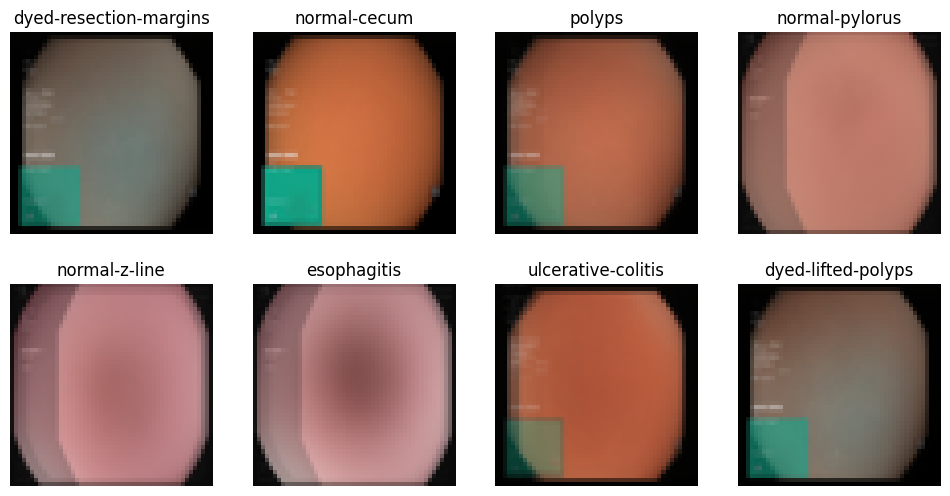

In [23]:
_, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()
for j,i in enumerate(train.Target.unique()):
    axes[j].imshow(np.mean(training_array[train.Target==i]/255.,axis=0))
    axes[j].axis('off')
    axes[j].set_title(i)
plt.show()

In 5 out of 8 classes, we observe green squares and that can generate bias. Therefore we will add a green square to each photo at the bottom left corner and then we will replace the green squares with black.

Black is (0,0,0) in RGB scale. The resulted element of the black square on the feature map will be 0, and therefore it will never be selected by max pooling.

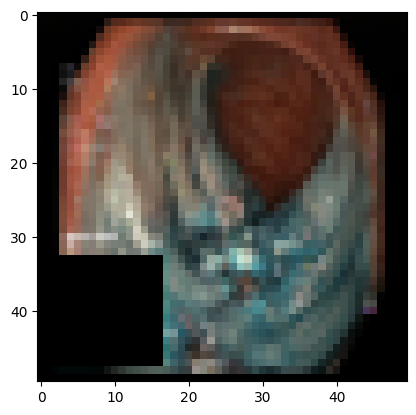

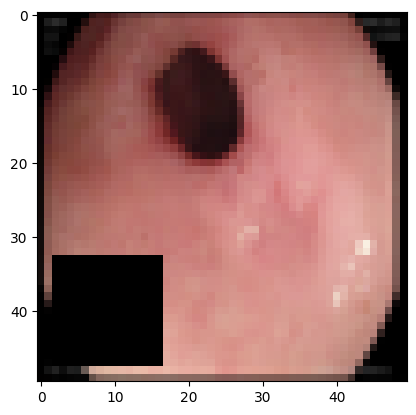

In [24]:
count = 0

for i,j in zip(training_array,df.Target):
    i[33:48,2:17] = np.zeros((15,15,3))
        

for i in test_array:
    i[33:48,2:17] = np.zeros((15,15,3))


for i in training_array:
    plt.imshow(i)
    plt.show()
    
    count += 1
    if count == 1:
        break

count = 0

for i in test_array:
    plt.imshow(i)
    plt.show()
    
    count += 1
    if count == 1:
        break

Now we will see the distribution of the Y variable in the training and test set.

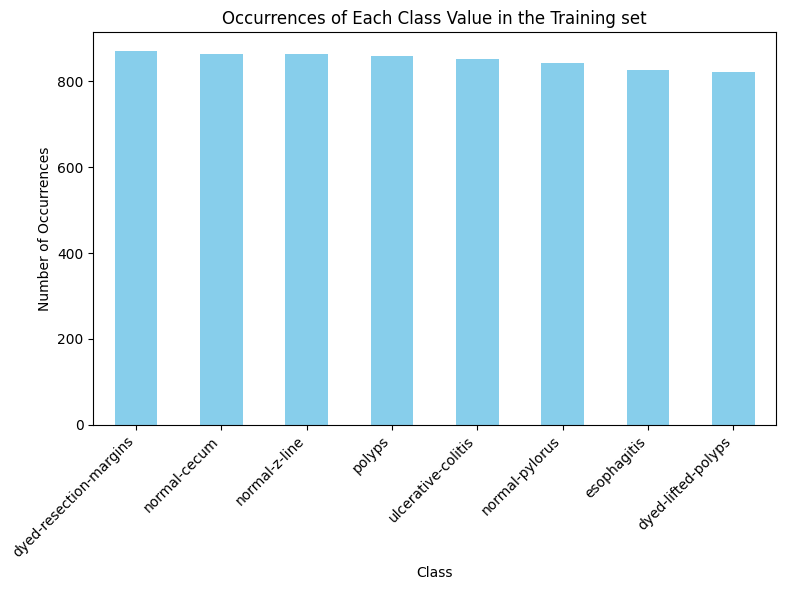

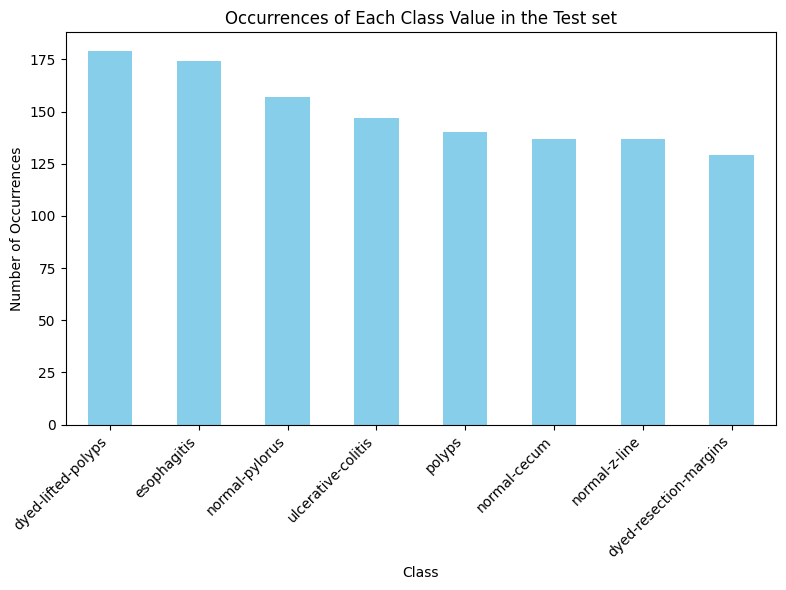

In [25]:
def plot_categorical_class(series,type:str):
    """
    Plot a bar plot showing the number of occurrences of each value of a categorical class.
    
    Parameters:
        series (pd.Series): A pandas Series representing the categorical class.
        
    Returns:
        None (displays the plot)
    """
    # Count the occurrences of each value in the series
    class_counts = series.value_counts()

    # Create a bar plot
    plt.figure(figsize=(8, 6))
    class_counts.plot(kind='bar', color='skyblue')
    
    # Add labels and title
    plt.xlabel('Class')
    plt.ylabel('Number of Occurrences')
    plt.title(f'Occurrences of Each Class Value in the {type} set')
    
    # Show plot
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()

plot_categorical_class(train['Target'],'Training')
plot_categorical_class(validation['Target'],'Test')

We will encode the labels of the Y variable.

In [30]:
#Since we have 8 classes, we will use softmax and we fix the Y variable accordingly.
enc = OrdinalEncoder()

Y_train = enc.fit_transform(train[['Target']])
Y_test = enc.fit_transform(validation[['Target']])

# 0 -> dyed-lifted-polyps
# 1 -> dyed-resection-margins
# 2 -> esophagitis
# 3 -> normal-cecum
# 4 -> normal-pylorus
# 5 -> normal-z-line
# 6 -> polyps
# 7 -> ulcerative-colitis

y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)


We apply Min-Max Normalisation

In [28]:


x_train = training_array
x_test = test_array.astype('float32')/255.

In [26]:
#!pip install scikeras
model = models.Sequential()
model.add(layers.Conv2D(16,(2,2),activation='relu',kernel_initializer='he_uniform',input_shape=(50,50,3),data_format = 'channels_last',strides = (2,2),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(16,activation='relu'))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(8,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

d:\Program Files\Projects\.conda\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 25, 25, 16)     │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25, 25, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        36,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,288 (145.66 KB)

 Trainable params: 37,256 (145.53 KB)

 Non-trainable params: 32 (128.00 B)

In [14]:
def bootstraping(X_y:tuple,model,n = 200):
    from sklearn.utils import resample
    n_bootstrap = n
    X_val, y_val = X_y[0], X_y[1]
    accuracy_values = []
    loss_values = []
    for _ in range(n_bootstrap):
    # Create a bootstrap sample of the validation data
        X_val_bootstrap, y_val_bootstrap = resample(X_val, y_val)    
    # Get accuracy and loss on the bootstrap sample
        val_loss, val_accuracy = model.evaluate(X_val_bootstrap, y_val_bootstrap,verbose=0)
    # Store accuracy and loss values
        accuracy_values.append(val_accuracy)
        loss_values.append(val_loss)
    return loss_values, accuracy_values
def list_from_lists(ls:list):

    flattened_list = [item for sublist in ls for item in sublist]
    return flattened_list


Baseline Model -> 1 Convolution Layer: Accuracy = 73.64%

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.3228 - loss: 1.7201 - val_accuracy: 0.2647 - val_loss: 2.1592
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6220 - loss: 0.9863 - val_accuracy: 0.3390 - val_loss: 1.7267
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6761 - loss: 0.7972 - val_accuracy: 0.4846 - val_loss: 1.3993
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7013 - loss: 0.7271 - val_accuracy: 0.5801 - val_loss: 1.1166
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7201 - loss: 0.6840 - val_accuracy: 0.6257 - val_loss: 0.9962
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7281 - loss: 0.6508 - val_accuracy: 0.6287 - val_loss: 0.9212
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7390 - loss: 0.6237 - val_accuracy: 0.6434 - val_loss: 0.8690
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7514 - loss: 0.6044 - val_accuracy: 0.6647 - v

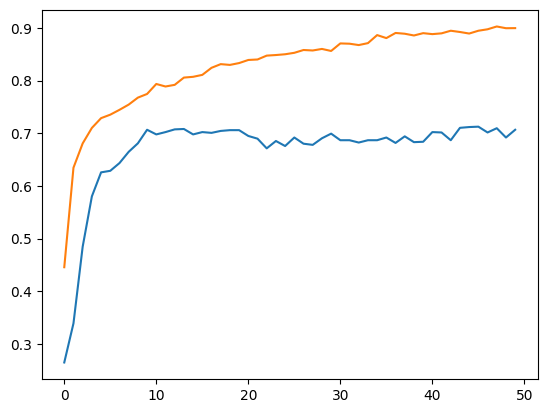

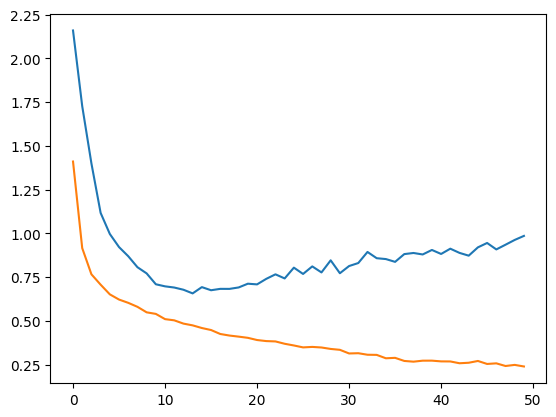

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.2711 - loss: 1.8102 - val_accuracy: 0.2029 - val_loss: 1.8752
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5521 - loss: 1.1329 - val_accuracy: 0.4199 - val_loss: 1.4219
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6319 - loss: 0.8795 - val_accuracy: 0.4993 - val_loss: 1.1804
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6804 - loss: 0.7696 - val_accuracy: 0.6000 - val_loss: 0.9806
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6976 - loss: 0.7119 - val_accuracy: 0.6353 - val_loss: 0.9096
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7129 - loss: 0.6700 - val_accuracy: 0.6684 - val_loss: 0.8583
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7184 - loss: 0.6449 - val_accuracy: 0.6412 - val_loss: 0.8796
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7365 - loss: 0.6164 - val_accuracy: 0.6279 - v

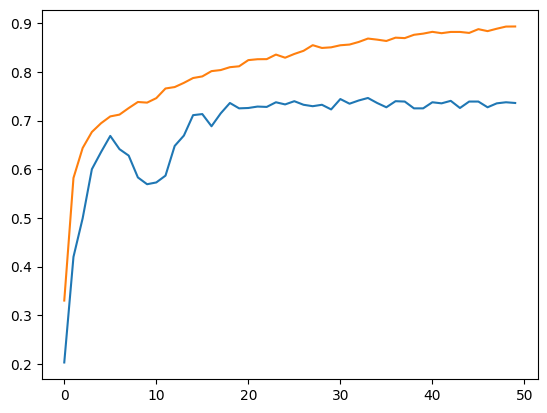

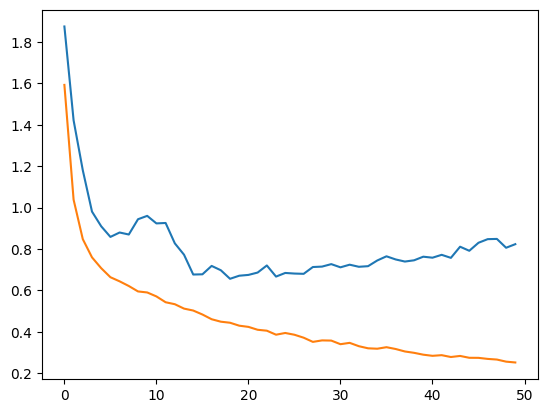

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.2900 - loss: 1.7833 - val_accuracy: 0.2471 - val_loss: 1.8917
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5400 - loss: 1.0384 - val_accuracy: 0.3081 - val_loss: 1.6662
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6050 - loss: 0.8831 - val_accuracy: 0.3228 - val_loss: 1.5039
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6481 - loss: 0.8016 - val_accuracy: 0.3419 - val_loss: 1.5008
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6672 - loss: 0.7533 - val_accuracy: 0.4103 - val_loss: 1.4044
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6904 - loss: 0.7048 - val_accuracy: 0.4618 - val_loss: 1.4109
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7175 - loss: 0.6544 - val_accuracy: 0.5154 - val_loss: 1.1874
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7214 - loss: 0.6354 - val_accuracy: 0.5529 - v

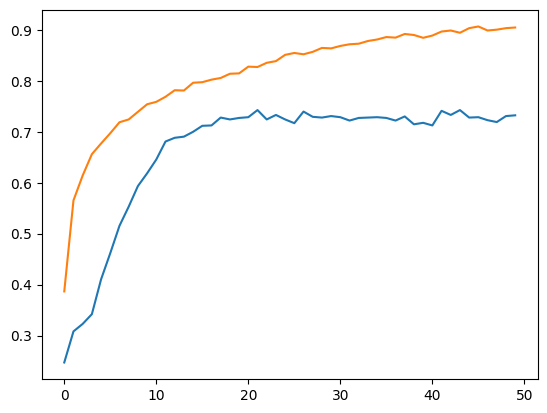

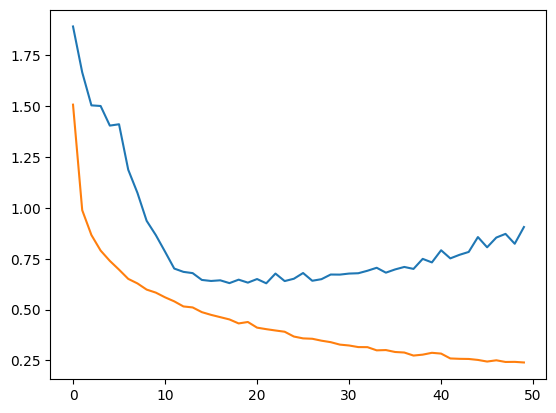

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.3899 - loss: 1.5475 - val_accuracy: 0.2603 - val_loss: 1.8193
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6219 - loss: 0.9063 - val_accuracy: 0.3044 - val_loss: 1.7904
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6782 - loss: 0.7463 - val_accuracy: 0.4096 - val_loss: 1.6303
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7148 - loss: 0.6590 - val_accuracy: 0.4779 - val_loss: 1.5101
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7198 - loss: 0.6342 - val_accuracy: 0.5235 - val_loss: 1.3752
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7404 - loss: 0.5947 - val_accuracy: 0.5456 - val_loss: 1.2633
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7482 - loss: 0.5811 - val_accuracy: 0.5735 - val_loss: 1.1079
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7595 - loss: 0.5518 - val_accuracy: 0.6257 - v

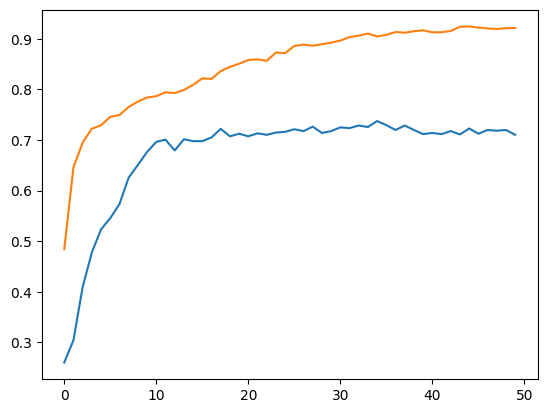

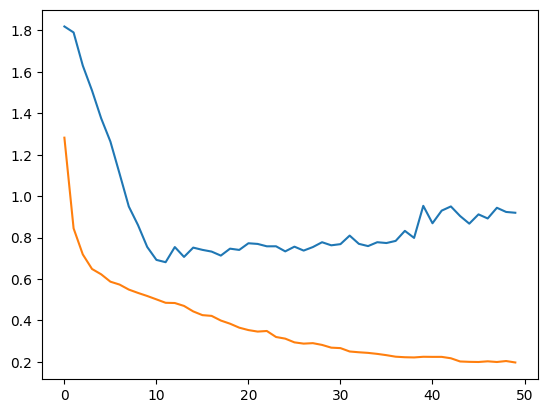

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.4048 - loss: 1.4706 - val_accuracy: 0.1654 - val_loss: 2.0979
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6209 - loss: 0.8385 - val_accuracy: 0.2699 - val_loss: 2.0376
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6800 - loss: 0.7196 - val_accuracy: 0.4066 - val_loss: 1.6697
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7243 - loss: 0.6473 - val_accuracy: 0.4794 - val_loss: 1.4501
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7386 - loss: 0.6023 - val_accuracy: 0.5132 - val_loss: 1.2929
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7545 - loss: 0.5687 - val_accuracy: 0.5772 - val_loss: 1.0653
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7750 - loss: 0.5393 - val_accuracy: 0.6228 - val_loss: 0.9279
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7755 - loss: 0.5157 - val_accuracy: 0.6397 - v

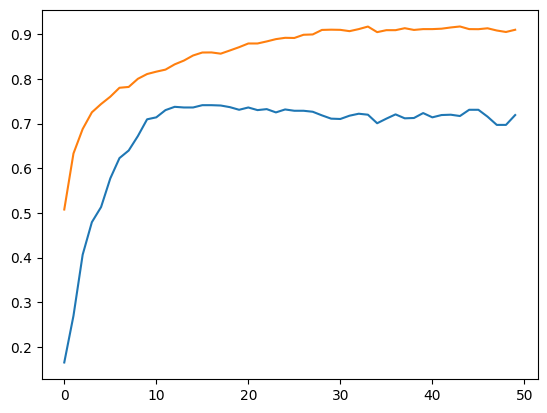

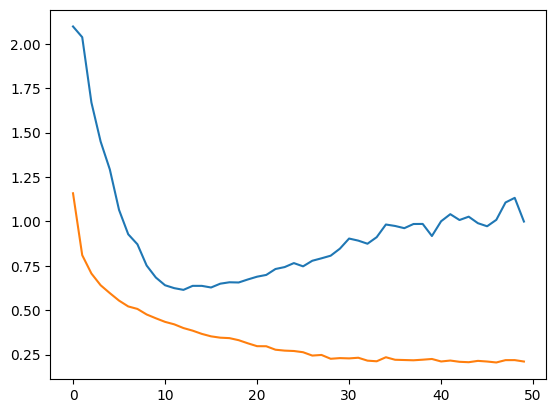

Accuracy:
Mean: 0.736444118976593, CI: (0.7349561129868672, 0.7379321249663188)
Loss:
Mean: 0.7386069270372391, CI: (0.7279243373354808, 0.7492895167389974)


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from scikeras.wrappers import KerasClassifier
filepath = r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\model.keras"
va_lo = []
va_ac = []
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(x_train,y_train)):
    cb = keras.callbacks.ModelCheckpoint(filepath, #filepath to save the model 
                                   monitor = "val_accuracy", #best val_accuracy will show which is the best model
                                   save_best_only = True)
    model = models.Sequential()
    model.add(layers.Conv2D(16,(2,2),activation='relu',kernel_initializer='he_uniform',input_shape=(50,50,3),data_format = 'channels_last',strides = (2,2),padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.05))
    model.add(layers.Dense(16,activation='relu'))
    model.add(layers.Dropout(0.05))
    model.add(layers.Dense(8,activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    x_tr, x_va = x_train[train_idx], x_train[val_idx]
    y_tr, y_va = y_train[train_idx], y_train[val_idx]
    x_tr = x_tr.astype("float32")/255.
    x_va = x_va.astype("float32")/255.
    history = model.fit(x_tr, y_tr ,epochs = 50, validation_data = (x_va, y_va), callbacks = [cb], batch_size=128)
    plt.plot(list(range(50)),history.history['val_accuracy'])
    plt.plot(list(range(50)),history.history['accuracy'])
    plt.show()
    plt.plot(list(range(50)),history.history['val_loss'])
    plt.plot(list(range(50)),history.history['loss'])
    plt.show()
    baseline = keras.models.load_model(r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\model.keras")
    nnn = 100
    val_los, val_acc = bootstraping((x_va,y_va), baseline, nnn)
    va_lo.append(val_los)
    va_ac.append(val_acc)

lolo = list_from_lists(va_lo)
acac = list_from_lists(va_ac)

accuracy_mean = np.mean(acac)
accuracy_std = np.std(acac)
accuracy_ci = (accuracy_mean - 1.96 * accuracy_std / np.sqrt((fold_idx+1)*nnn), accuracy_mean + 1.96 * accuracy_std / np.sqrt((fold_idx+1)*nnn))

loss_mean = np.mean(lolo)
loss_std = np.std(lolo)
loss_ci = (loss_mean - 1.96 * loss_std / np.sqrt((fold_idx+1)*nnn), loss_mean + 1.96 * loss_std / np.sqrt((fold_idx+1)*nnn))

print("Accuracy:")
print(f"Mean: {accuracy_mean}, CI: {accuracy_ci}")
print("Loss:")
print(f"Mean: {loss_mean}, CI: {loss_ci}")


In [17]:
baseline = keras.models.load_model(r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\model.keras") #We load the best model

Training Loss stands at 0.25. We will use more complex model.

In [18]:
baseline.evaluate(x_test,y_test) #We evaluate the test set

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7232 - loss: 0.6416


[0.6119706630706787, 0.7208333611488342]

Second Model -> 2 Convolution Layers: Accuracy = 73.85%

In [21]:
#a better model
def get_model():
    model1 = models.Sequential()
    model1.add(layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_uniform',input_shape=(50,50,3),data_format = 'channels_last',padding='same'))
    model1.add(layers.BatchNormalization())
    model1.add(layers.MaxPooling2D((2,2)))

    model1.add(layers.Conv2D(32,(2,2),activation='relu',kernel_initializer='he_uniform',data_format = 'channels_last'))
    model1.add(layers.BatchNormalization())
    model1.add(layers.MaxPooling2D((2,2)))

    model1.add(layers.Flatten())
    model1.add(layers.Dense(256,activation='relu'))
    model1.add(layers.Dropout(0.1))
    model1.add(layers.Dense(128,activation='relu'))
    model1.add(layers.Dropout(0.1))
    model1.add(layers.Dense(64,activation='relu'))

    model1.add(layers.Dense(8,activation='softmax'))
    return model1

model1 = get_model()
model1.save_weights('initial_weights.weights.h5')


In [22]:
get_model().summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 50, 50, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 24, 24, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,231,976 (4.70 MB)

 Trainable params: 1,231,784 (4.70 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 439ms/step - accuracy: 0.4497 - loss: 1.5348 - val_accuracy: 0.2176 - val_loss: 1.8101
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 420ms/step - accuracy: 0.6861 - loss: 0.7045 - val_accuracy: 0.2794 - val_loss: 1.7535
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 419ms/step - accuracy: 0.7201 - loss: 0.6336 - val_accuracy: 0.3471 - val_loss: 1.7349
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 419ms/step - accuracy: 0.7547 - loss: 0.5692 - val_accuracy: 0.3978 - val_loss: 1.5500
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 516ms/step - accuracy: 0.7787 - loss: 0.5339 - val_accuracy: 0.4176 - val_loss: 1.4776
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 422ms/step - accuracy: 0.7917 - loss: 0.4655 - val_accuracy: 0.4971 - val_loss: 1.2593
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 423ms/step - accuracy: 0.8268 - loss: 0.3966 - val_accuracy: 0.5684 - val_loss: 1.1395
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 426ms/step - accuracy: 0.8553 - loss: 0.3434 - val_accu

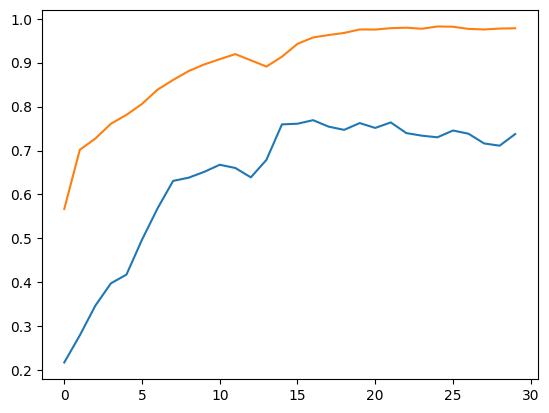

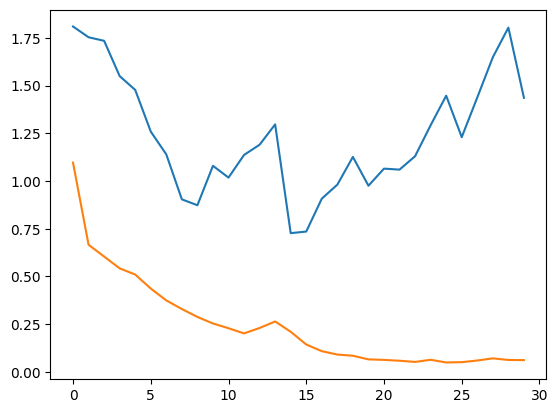

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 440ms/step - accuracy: 0.4724 - loss: 1.4507 - val_accuracy: 0.3074 - val_loss: 1.6353
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 418ms/step - accuracy: 0.6869 - loss: 0.7035 - val_accuracy: 0.2882 - val_loss: 1.7895
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 414ms/step - accuracy: 0.7408 - loss: 0.5942 - val_accuracy: 0.3706 - val_loss: 1.6534
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 418ms/step - accuracy: 0.7647 - loss: 0.5480 - val_accuracy: 0.3735 - val_loss: 1.7672
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 420ms/step - accuracy: 0.7821 - loss: 0.4958 - val_accuracy: 0.4985 - val_loss: 1.2821
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 418ms/step - accuracy: 0.8086 - loss: 0.4412 - val_accuracy: 0.4772 - val_loss: 1.3695
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 413ms/step - accuracy: 0.8226 - loss: 0.4003 - val_accuracy: 0.5353 - val_loss: 1.2853
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 417ms/step - accuracy: 0.8468 - loss: 0.3534 - val_accu

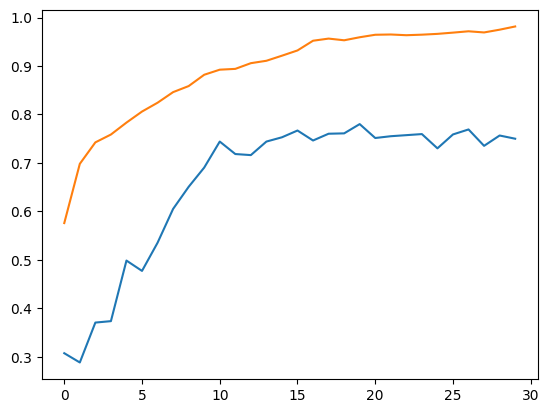

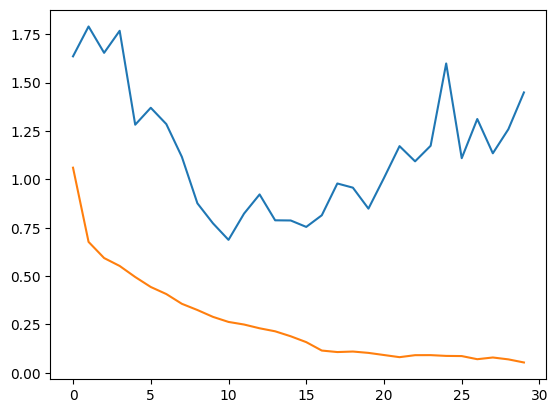

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 413ms/step - accuracy: 0.4455 - loss: 1.5037 - val_accuracy: 0.2772 - val_loss: 1.7267
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 391ms/step - accuracy: 0.6930 - loss: 0.6824 - val_accuracy: 0.2853 - val_loss: 1.6040
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 415ms/step - accuracy: 0.7315 - loss: 0.6088 - val_accuracy: 0.3441 - val_loss: 1.5113
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 406ms/step - accuracy: 0.7669 - loss: 0.5254 - val_accuracy: 0.3500 - val_loss: 1.5855
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 446ms/step - accuracy: 0.7932 - loss: 0.4817 - val_accuracy: 0.3993 - val_loss: 1.4729
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 425ms/step - accuracy: 0.8083 - loss: 0.4447 - val_accuracy: 0.4735 - val_loss: 1.4033
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 454ms/step - accuracy: 0.8224 - loss: 0.3967 - val_accuracy: 0.5882 - val_loss: 1.0749
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 429ms/step - accuracy: 0.8520 - loss: 0.3409 - val_accu

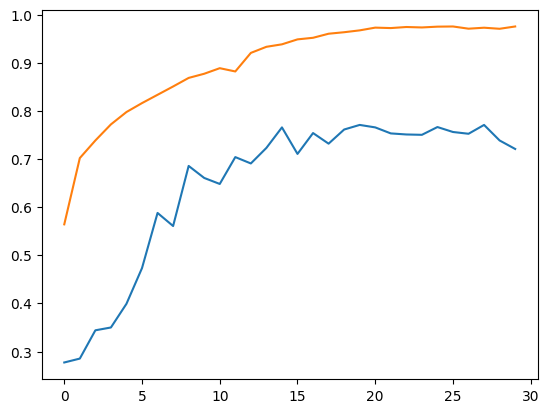

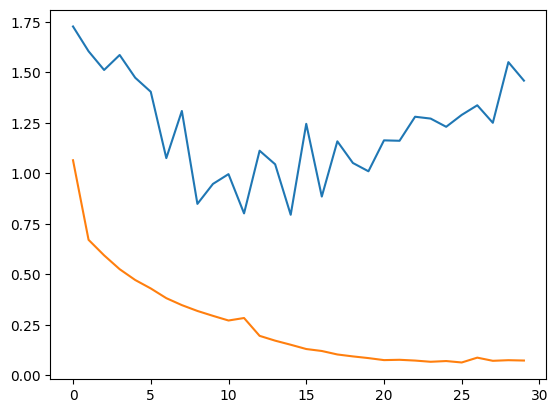

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 28s 458ms/step - accuracy: 0.4777 - loss: 1.4330 - val_accuracy: 0.2287 - val_loss: 1.7460
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 417ms/step - accuracy: 0.7045 - loss: 0.6757 - val_accuracy: 0.2206 - val_loss: 2.1379
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 412ms/step - accuracy: 0.7467 - loss: 0.5882 - val_accuracy: 0.2684 - val_loss: 2.3152
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 417ms/step - accuracy: 0.7753 - loss: 0.5439 - val_accuracy: 0.2735 - val_loss: 2.2579
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 415ms/step - accuracy: 0.7924 - loss: 0.4833 - val_accuracy: 0.4074 - val_loss: 1.6602
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 418ms/step - accuracy: 0.8273 - loss: 0.4031 - val_accuracy: 0.4346 - val_loss: 1.7529
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 410ms/step - accuracy: 0.8557 - loss: 0.3530 - val_accuracy: 0.4610 - val_loss: 2.0615
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 414ms/step - accuracy: 0.8668 - loss: 0.3199 - val_accu

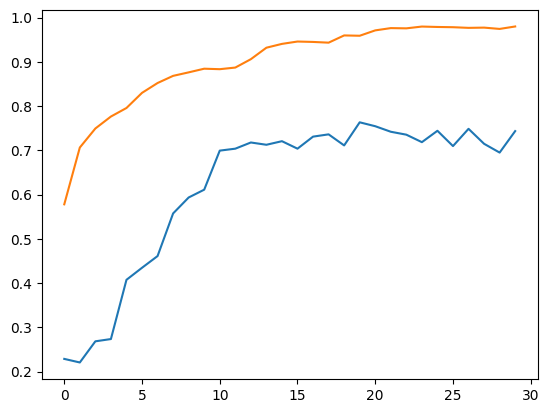

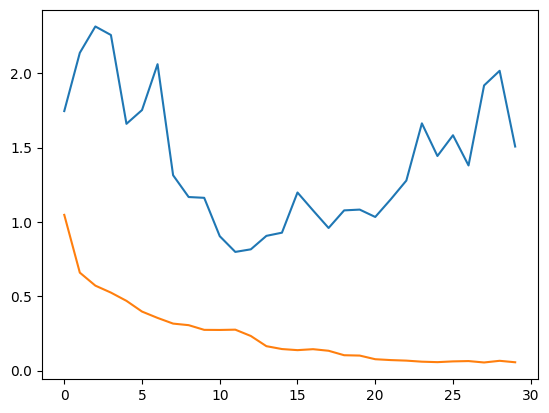

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 417ms/step - accuracy: 0.4948 - loss: 1.3842 - val_accuracy: 0.1838 - val_loss: 1.9185
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 404ms/step - accuracy: 0.6974 - loss: 0.6906 - val_accuracy: 0.2463 - val_loss: 1.9268
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 434ms/step - accuracy: 0.7279 - loss: 0.6038 - val_accuracy: 0.3338 - val_loss: 1.5910
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 426ms/step - accuracy: 0.7587 - loss: 0.5511 - val_accuracy: 0.3647 - val_loss: 1.7441
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 419ms/step - accuracy: 0.7760 - loss: 0.5250 - val_accuracy: 0.4294 - val_loss: 1.4640
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 421ms/step - accuracy: 0.7946 - loss: 0.4807 - val_accuracy: 0.5022 - val_loss: 1.2502
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 477ms/step - accuracy: 0.8240 - loss: 0.4190 - val_accuracy: 0.5485 - val_loss: 1.2012
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 451ms/step - accuracy: 0.8461 - loss: 0.3610 - val_accu

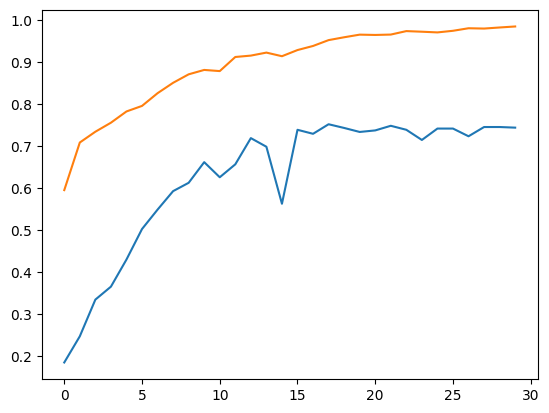

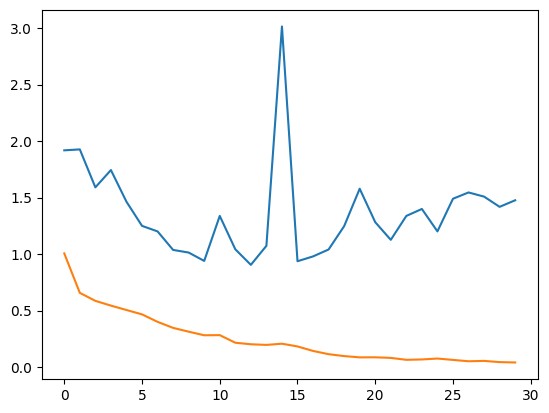

Accuracy:
Mean: 0.7385544111728668, CI: (0.7361674386454726, 0.740941383700261)
Loss:
Mean: 0.7830996502637864, CI: (0.7756810544659991, 0.7905182460615736)
mean val loss 0.7830996502637864
stdiv val loss 0.08463512500738007
mean val acc 0.7385544111728668
stdiv val acc 0.027231800161621748


In [23]:
filepath = r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\model1.keras" #Same logic for the second model
va_lo = []
va_ac = []
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(x_train,y_train)):
    cb1 = keras.callbacks.ModelCheckpoint(filepath,
                                   monitor = "val_loss",
                                   save_best_only = True)
    model1 = get_model()
    model1.load_weights('initial_weights.weights.h5')
    x_tr, x_va = x_train[train_idx], x_train[val_idx]
    y_tr, y_va = y_train[train_idx], y_train[val_idx]
    x_tr = x_tr.astype("float32")/255.
    x_va = x_va.astype("float32")/255.
    model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    history = model1.fit(x_tr, y_tr ,epochs = 30, validation_data = (x_va, y_va), callbacks = [cb1],batch_size=128)
    plt.plot(list(range(30)),history.history['val_accuracy'])
    plt.plot(list(range(30)),history.history['accuracy'])
    plt.show()
    plt.plot(list(range(30)),history.history['val_loss'])
    plt.plot(list(range(30)),history.history['loss'])
    plt.show()
    better_model = keras.models.load_model(r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\model1.keras")
    nnn = 100
    val_los, val_acc = bootstraping((x_va,y_va), better_model, nnn)
    va_lo.append(val_los)
    va_ac.append(val_acc)

lolo = list_from_lists(va_lo)
acac = list_from_lists(va_ac)

accuracy_mean = np.mean(acac)
accuracy_std = np.std(acac)
accuracy_ci = (accuracy_mean - 1.96 * accuracy_std / np.sqrt((fold_idx+1)*nnn), accuracy_mean + 1.96 * accuracy_std / np.sqrt((fold_idx+1)*nnn))

loss_mean = np.mean(lolo)
loss_std = np.std(lolo)
loss_ci = (loss_mean - 1.96 * loss_std / np.sqrt((fold_idx+1)*nnn), loss_mean + 1.96 * loss_std / np.sqrt((fold_idx+1)*nnn))

print("Accuracy:")
print(f"Mean: {accuracy_mean}, CI: {accuracy_ci}")
print("Loss:")
print(f"Mean: {loss_mean}, CI: {loss_ci}")
print("mean val loss",np.mean(va_lo))
print("stdiv val loss",np.std(va_lo))
print("mean val acc", np.mean(va_ac))
print("stdiv val acc", np.std(va_ac))


In [24]:
better_model = keras.models.load_model(r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\model1.keras")
better_model.evaluate(x_test,y_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6916 - loss: 0.9884


[0.9813326597213745, 0.6991666555404663]

Data Augmentation techniques to make the model generalise and avoid overfitting.

In [26]:

def bootstraping1(val_ds,model,n = 200):
    from sklearn.utils import resample
    n_bootstrap = n

    accuracy_values = []
    loss_values = []
    for _ in range(n_bootstrap):
    # Create a bootstrap sample of the validation data
        val_ds_bootstrap = val_ds.shuffle(buffer_size=len(val_ds)).take(len(val_ds))
    
    # Create CNN model
    
    # Get accuracy and loss on the bootstrap sample
        val_loss, val_accuracy = model.evaluate(val_ds_bootstrap,verbose=0)
    # Store accuracy and loss values
        accuracy_values.append(val_accuracy)
        loss_values.append(val_loss)
    return loss_values, accuracy_values

First Data Augmentation Technique = MixUp -> Accuracy: 75.01%

More info on https://keras.io/examples/vision/mixup/

[0.0, 0.8807215094566345, 0.0, 0.0, 0.11927849054336548, 0.0, 0.0, 0.0]
[0.9805200695991516, 0.0, 0.0, 0.0, 0.0, 0.01947993040084839, 0.0, 0.0]
[0.0, 0.0, 0.8218957185745239, 0.17810429632663727, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.9287703037261963, 0.07122969627380371, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.8050583004951477, 0.0, 0.0, 0.0, 0.0, 0.1949416995048523]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.00018602609634399414, 0.999813973903656, 0.0]
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.47806316614151, 0.0, 0.52193683385849, 0.0, 0.0, 0.0, 0.0]
[0.6041489839553833, 0.3958509862422943, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


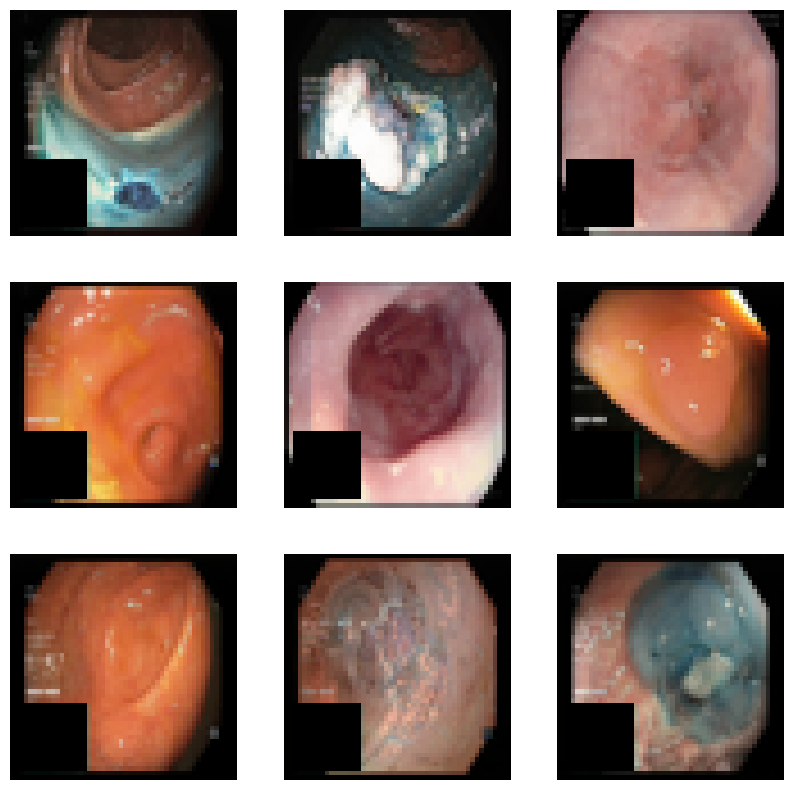

Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 299ms/step - accuracy: 0.4704 - loss: 1.5245 - val_accuracy: 0.2971 - val_loss: 1.7901
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 271ms/step - accuracy: 0.6479 - loss: 0.9934 - val_accuracy: 0.4662 - val_loss: 1.4251
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 24s 270ms/step - accuracy: 0.6980 - loss: 0.9205 - val_accuracy: 0.5316 - val_loss: 1.2805
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 24s 270ms/step - accuracy: 0.7190 - loss: 0.8585 - val_accuracy: 0.6257 - val_loss: 0.9494
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 282ms/step - accuracy: 0.7247 - loss: 0.8568 - val_accuracy: 0.6331 - val_loss: 0.9350
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 27s 315ms/step - accuracy: 0.7389 - loss: 0.8159 - val_accuracy: 0.7118 - val_loss: 0.6948
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 26s 299ms/step - accuracy: 0.7657 - loss: 0.7900 - val_accuracy: 0.6919 - val_loss: 0.7559
Epoch 8/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 292ms/step - accuracy: 0.7959 - loss: 0.7367 - val_accu

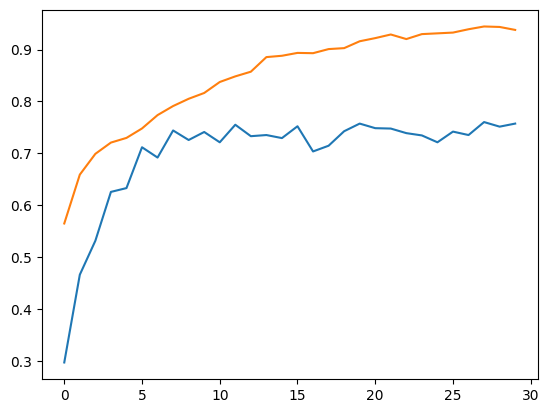

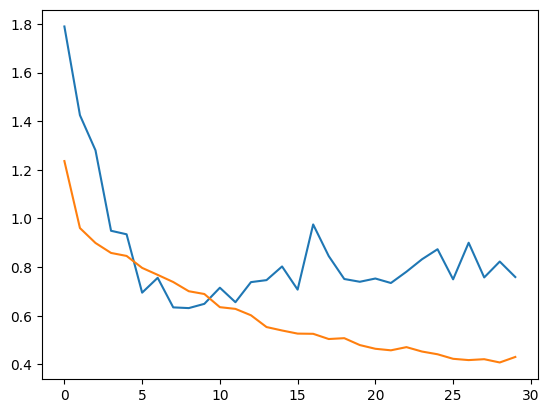

[0.0, 0.11927849054336548, 0.0, 0.8807215094566345, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.01947993040084839, 0.0, 0.9805200695991516, 0.0, 0.0]
[0.0, 0.8218957185745239, 0.17810429632663727, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.9287703037261963, 0.0, 0.0, 0.07122969627380371, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[0.0, 0.00018602609634399414, 0.0, 0.0, 0.0, 0.0, 0.0, 0.999813973903656]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.16281390190124512, 0.8371860980987549, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.6041489839553833, 0.0, 0.3958509862422943, 0.0, 0.0]


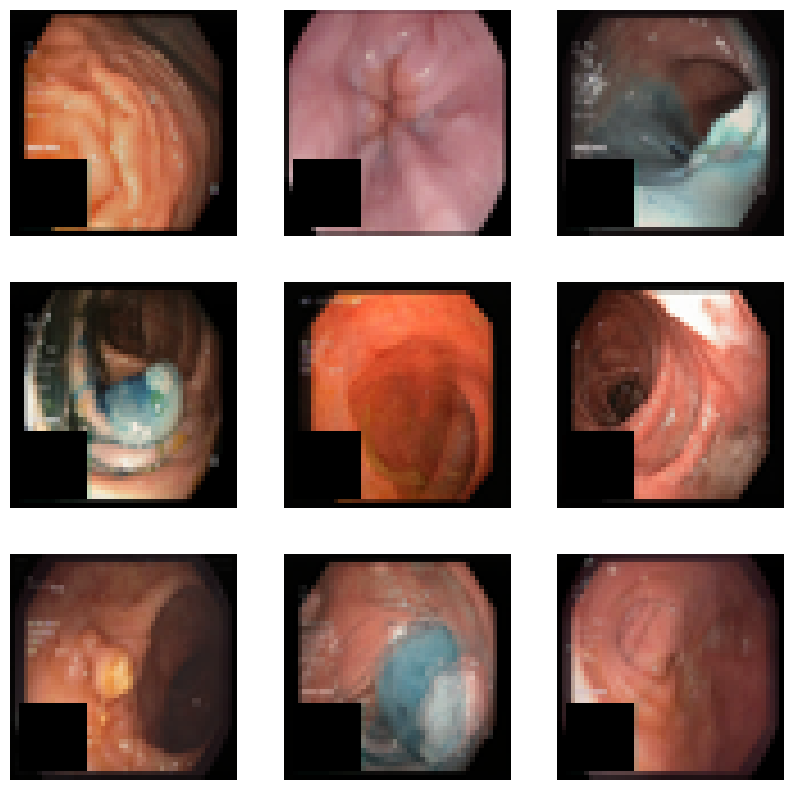

Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 32s 277ms/step - accuracy: 0.4810 - loss: 1.5287 - val_accuracy: 0.4132 - val_loss: 1.5560
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 256ms/step - accuracy: 0.6605 - loss: 0.9890 - val_accuracy: 0.5618 - val_loss: 1.3984
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 257ms/step - accuracy: 0.6900 - loss: 0.9293 - val_accuracy: 0.6162 - val_loss: 1.1918
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 257ms/step - accuracy: 0.7165 - loss: 0.8726 - val_accuracy: 0.6206 - val_loss: 1.0394
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 267ms/step - accuracy: 0.7283 - loss: 0.8369 - val_accuracy: 0.6941 - val_loss: 0.8747
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 24s 274ms/step - accuracy: 0.7561 - loss: 0.8110 - val_accuracy: 0.7441 - val_loss: 0.6689
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 261ms/step - accuracy: 0.7620 - loss: 0.7719 - val_accuracy: 0.7647 - val_loss: 0.6079
Epoch 8/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 262ms/step - accuracy: 0.7978 - loss: 0.7332 - val_accu

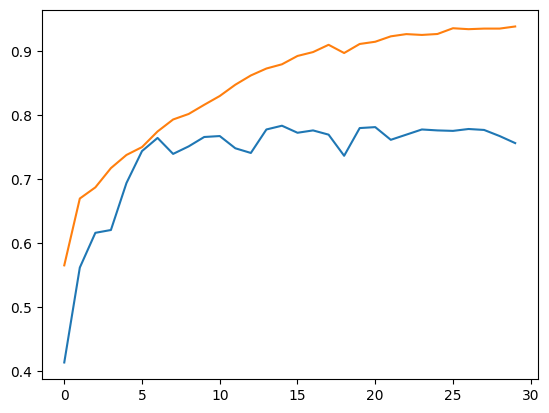

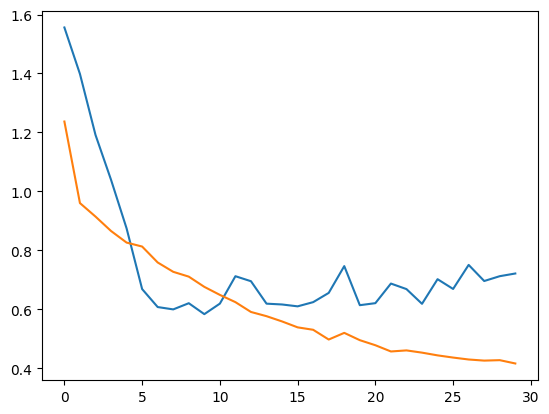

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.01947993040084839, 0.0, 0.9805200695991516]
[0.0, 0.8218957185745239, 0.0, 0.0, 0.17810429632663727, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.9287703037261963, 0.0, 0.0, 0.07122969627380371, 0.0]
[0.0, 0.8050583004951477, 0.0, 0.0, 0.0, 0.1949416995048523, 0.0, 0.0]
[0.999813973903656, 0.00018602609634399414, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.16281390190124512, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8371860980987549]
[0.0, 0.52193683385849, 0.0, 0.0, 0.0, 0.0, 0.0, 0.47806316614151]
[0.0, 0.0, 0.0, 0.3958509862422943, 0.6041489839553833, 0.0, 0.0, 0.0]


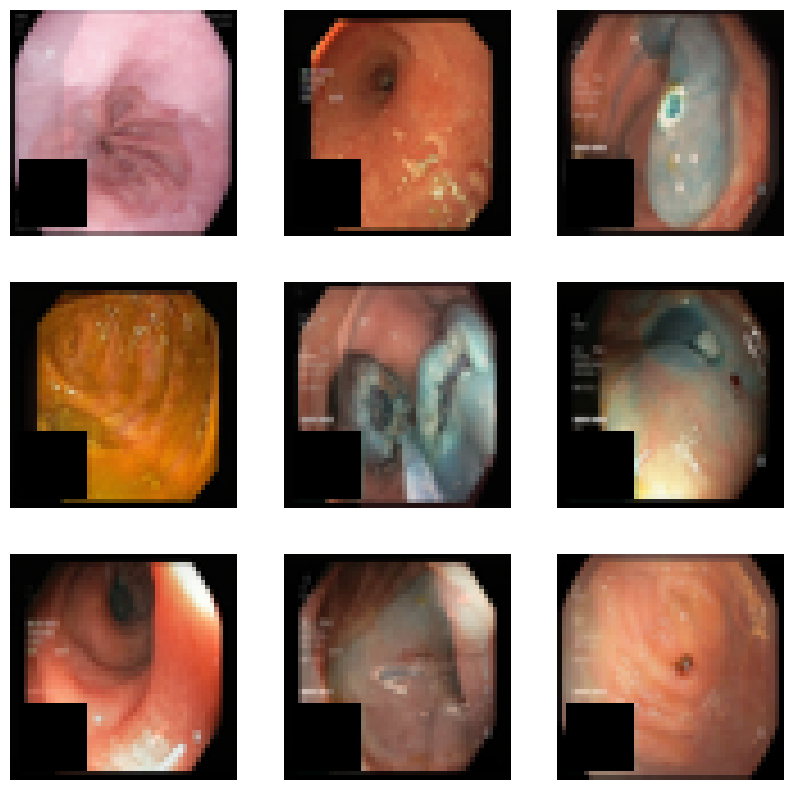

Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 29s 259ms/step - accuracy: 0.4484 - loss: 1.5659 - val_accuracy: 0.3676 - val_loss: 1.6827
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 245ms/step - accuracy: 0.6711 - loss: 0.9805 - val_accuracy: 0.5074 - val_loss: 1.4422
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 247ms/step - accuracy: 0.6761 - loss: 0.9364 - val_accuracy: 0.5728 - val_loss: 1.2942
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 248ms/step - accuracy: 0.7216 - loss: 0.8748 - val_accuracy: 0.6250 - val_loss: 1.0808
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 246ms/step - accuracy: 0.7418 - loss: 0.8239 - val_accuracy: 0.6397 - val_loss: 0.9797
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 967ms/step - accuracy: 0.7413 - loss: 0.8128 - val_accuracy: 0.7206 - val_loss: 0.7122
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 27s 295ms/step - accuracy: 0.7691 - loss: 0.7995 - val_accuracy: 0.7081 - val_loss: 0.6620
Epoch 8/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 28s 325ms/step - accuracy: 0.7720 - loss: 0.7590 - val_accu

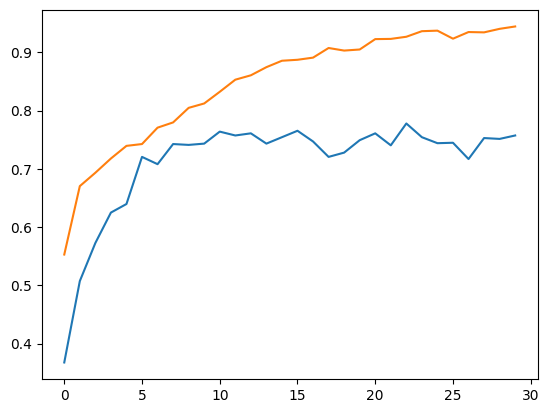

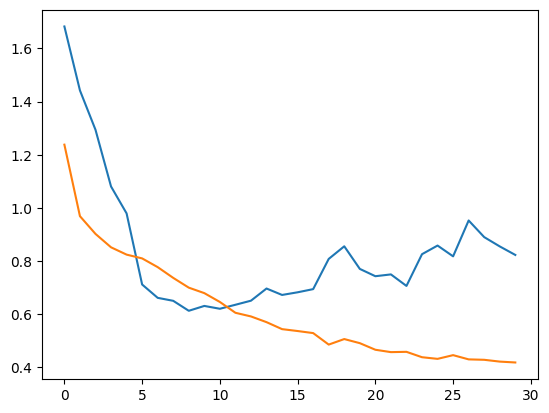

[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.01947993040084839, 0.9805200695991516, 0.0]
[0.8218957185745239, 0.0, 0.0, 0.17810429632663727, 0.0, 0.0, 0.0, 0.0]
[0.9287703037261963, 0.0, 0.0, 0.0, 0.07122969627380371, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.1949416995048523, 0.8050583004951477, 0.0]
[0.0, 0.0, 0.00018602609634399414, 0.0, 0.0, 0.0, 0.0, 0.999813973903656]
[0.0, 0.0, 0.0, 0.0, 0.8371860980987549, 0.16281390190124512, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.47806316614151, 0.52193683385849, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3958509862422943, 0.6041489839553833]


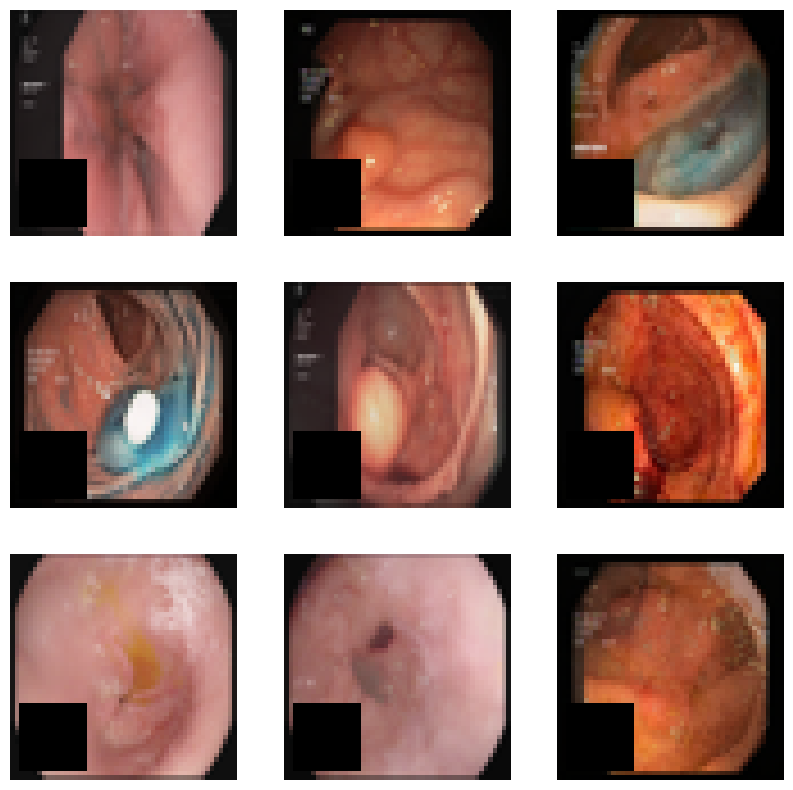

Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 28s 257ms/step - accuracy: 0.4756 - loss: 1.4985 - val_accuracy: 0.3904 - val_loss: 1.6187
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 253ms/step - accuracy: 0.6457 - loss: 0.9996 - val_accuracy: 0.5574 - val_loss: 1.4187
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 254ms/step - accuracy: 0.6931 - loss: 0.9423 - val_accuracy: 0.5838 - val_loss: 1.1469
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 249ms/step - accuracy: 0.7063 - loss: 0.8880 - val_accuracy: 0.7162 - val_loss: 0.8605
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 249ms/step - accuracy: 0.7538 - loss: 0.8181 - val_accuracy: 0.7125 - val_loss: 0.7714
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 246ms/step - accuracy: 0.7596 - loss: 0.7892 - val_accuracy: 0.6978 - val_loss: 0.7741
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 252ms/step - accuracy: 0.7609 - loss: 0.7830 - val_accuracy: 0.7316 - val_loss: 0.6675
Epoch 8/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 264ms/step - accuracy: 0.8067 - loss: 0.7137 - val_accu

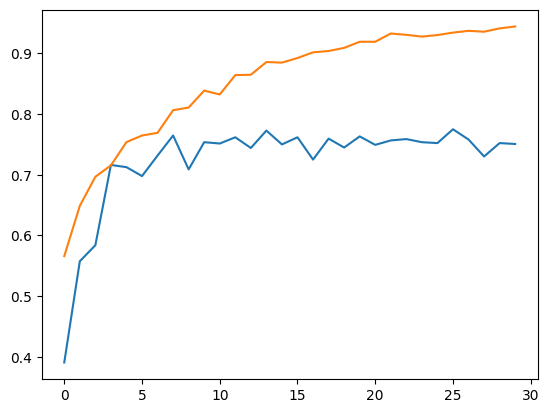

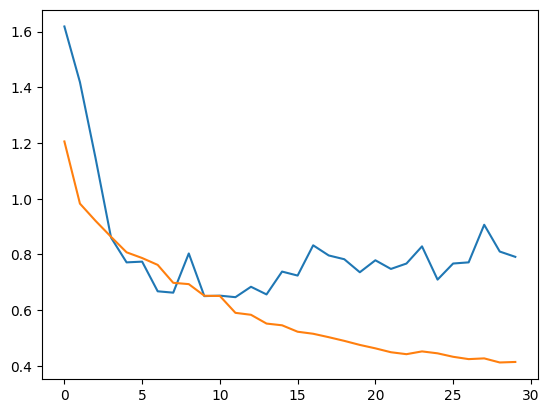

[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.9805200695991516, 0.01947993040084839, 0.0, 0.0]
[0.17810429632663727, 0.8218957185745239, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.07122969627380371, 0.0, 0.0, 0.0, 0.9287703037261963, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.8050583004951477, 0.0, 0.0, 0.1949416995048523]
[0.0, 0.0, 0.0, 0.999813973903656, 0.0, 0.0, 0.00018602609634399414, 0.0]
[0.0, 0.0, 0.8371860980987549, 0.16281390190124512, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


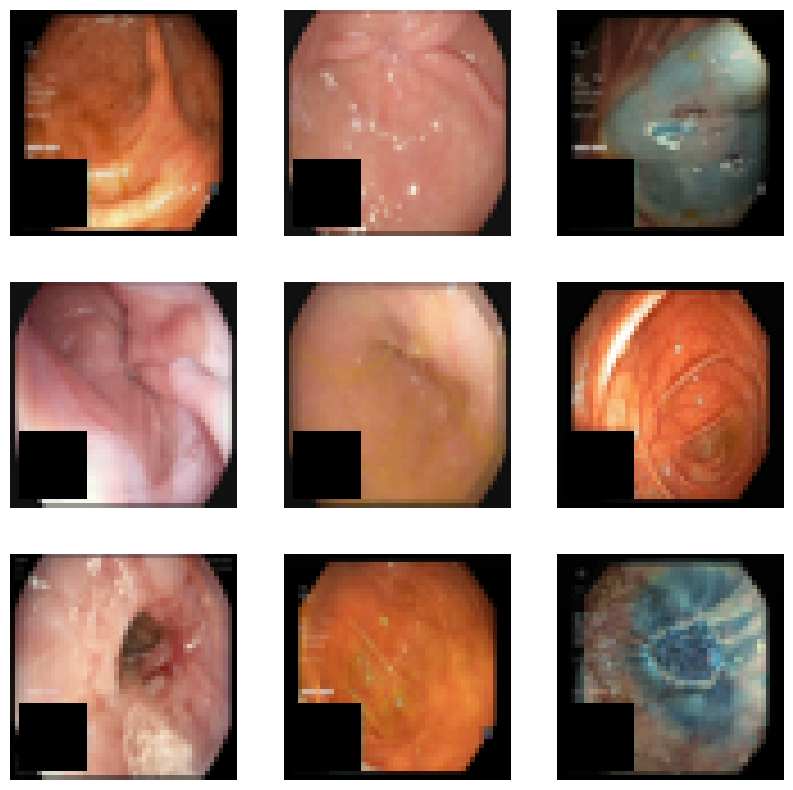

Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 340ms/step - accuracy: 0.4560 - loss: 1.5393 - val_accuracy: 0.4265 - val_loss: 1.6258
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 258ms/step - accuracy: 0.6465 - loss: 0.9964 - val_accuracy: 0.4868 - val_loss: 1.4794
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 260ms/step - accuracy: 0.6859 - loss: 0.9438 - val_accuracy: 0.5610 - val_loss: 1.2736
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 272ms/step - accuracy: 0.7125 - loss: 0.8712 - val_accuracy: 0.6676 - val_loss: 1.0136
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 271ms/step - accuracy: 0.7414 - loss: 0.8571 - val_accuracy: 0.6735 - val_loss: 0.8757
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 267ms/step - accuracy: 0.7369 - loss: 0.8281 - val_accuracy: 0.6912 - val_loss: 0.7768
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 42s 282ms/step - accuracy: 0.7561 - loss: 0.7807 - val_accuracy: 0.7456 - val_loss: 0.6540
Epoch 8/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 24s 280ms/step - accuracy: 0.7860 - loss: 0.7497 - val_accu

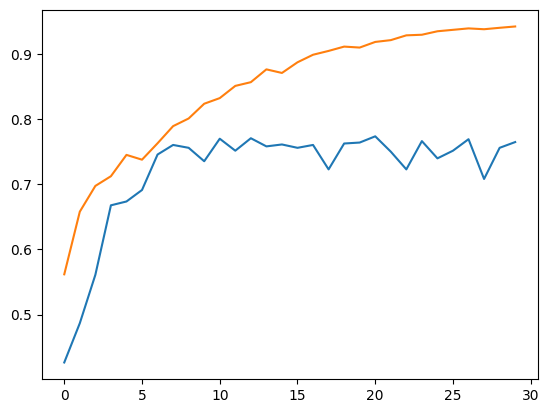

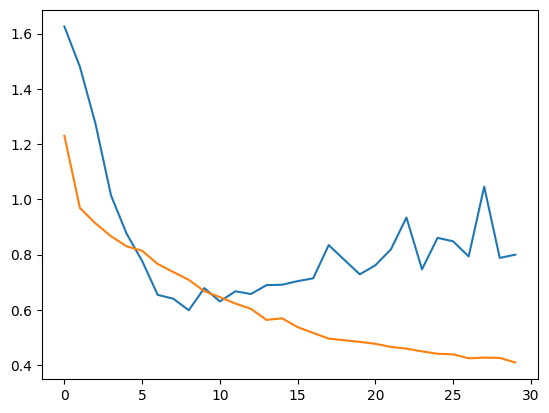

Accuracy:
Mean: 0.7501470685005188, CI: (0.7488462365782592, 0.7514479004227784)
Loss:
Mean: 0.6145930593013763, CI: (0.612630191981899, 0.6165559266208536)
mean val loss 0.6145930593013763
stdiv val loss 0.022393391618182924
mean val acc 0.7501470685005188
stdiv val acc 0.014840554109561636


In [27]:
#Mix up
def sample_beta_distribution(size, concentration_0=2, concentration_1=0.5): #beta distribution
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2): #Mix up to merge two images
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    images_one = tf.cast(images_one, tf.float32)
    images_two = tf.cast(images_two, tf.float32)
    labels_one = tf.cast(labels_one, tf.float32)
    labels_two = tf.cast(labels_two, tf.float32)

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)
#cross fold from here


filepath = r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\mixup.keras" #Same logic for the second model
va_lo = []
va_ac = []
BATCH_SIZE = 64
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(x_train,y_train)):
    model2 = get_model()
    model2.load_weights('initial_weights.weights.h5')

    model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])



    #filepath = r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\mixup.keras"
    cb1 = keras.callbacks.ModelCheckpoint(filepath,
                                   monitor = "val_loss",
                                   save_best_only = True)
    x_tr, x_va = x_train[train_idx], x_train[val_idx]
    y_tr, y_va = y_train[train_idx], y_train[val_idx]
    x_tr = x_tr.astype("float32")/255.
    x_va = x_va.astype("float32")/255.

    
    train_ds_one = (
        tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
        .shuffle(BATCH_SIZE * 100)
        .batch(BATCH_SIZE)
    )
    train_ds_two = (
        tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
        .shuffle(BATCH_SIZE * 100)
        .batch(BATCH_SIZE)
    )
    # Because we will be mixing up the images and their corresponding labels, we will be
    # combining two shuffled datasets from the same training data.
    train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

    val_ds = tf.data.Dataset.from_tensor_slices((x_va, y_va)).batch(BATCH_SIZE)

    

    AUTO = tf.data.AUTOTUNE #Constructing the dataset and ploting some images from the dataset
    train_ds_mu = train_ds.map(
        lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO
    )

    # Let's preview 9 samples from the dataset
    sample_images, sample_labels = next(iter(train_ds_mu))
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().squeeze())
        print(label.numpy().tolist())
        plt.axis("off")
    plt.show()
    history2 = model2.fit(train_ds_mu,epochs = 30, validation_data = val_ds, callbacks = [cb1])
    plt.plot(list(range(30)),history2.history['val_accuracy'])
    plt.plot(list(range(30)),history2.history['accuracy'])
    plt.show()
    plt.plot(list(range(30)),history2.history['val_loss'])
    plt.plot(list(range(30)),history2.history['loss'])
    plt.show()
    mix_up_model = keras.models.load_model(r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\mixup.keras")
    nnn = 100
    val_los, val_acc = bootstraping1(val_ds, mix_up_model, nnn)
    va_lo.append(val_los)
    va_ac.append(val_acc)

lolo = list_from_lists(va_lo)
acac = list_from_lists(va_ac)
#print(fold_idx)

accuracy_mean = np.mean(acac)
accuracy_std = np.std(acac)
accuracy_ci = (accuracy_mean - 1.96 * accuracy_std / np.sqrt((fold_idx+1)*nnn), accuracy_mean + 1.96 * accuracy_std / np.sqrt((fold_idx+1)*nnn))

loss_mean = np.mean(lolo)
loss_std = np.std(lolo)
loss_ci = (loss_mean - 1.96 * loss_std / np.sqrt((fold_idx+1)*nnn), loss_mean + 1.96 * loss_std / np.sqrt((fold_idx+1)*nnn))

print("Accuracy:")
print(f"Mean: {accuracy_mean}, CI: {accuracy_ci}")
print("Loss:")
print(f"Mean: {loss_mean}, CI: {loss_ci}")
    
print("mean val loss",np.mean(va_lo))
print("stdiv val loss",np.std(va_lo))
print("mean val acc", np.mean(va_ac))
print("stdiv val acc", np.std(va_ac))
#his
    #model

In [28]:
mix_up_model = keras.models.load_model(r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\mixup.keras")
mix_up_model.evaluate(test_ds)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7232 - loss: 0.6354


[0.6151605248451233, 0.7333333492279053]

Second Data Augmentation Technique CutMix -> Accuracy: 77.69%

More info on https://keras.io/examples/vision/cutmix/

In [33]:
#Cut mix
def preprocess_image(image, label):
    IMG_SIZE = 50
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

@tf.function
def get_box(lambda_value):
    
    IMG_SIZE = 50
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    #image1 = tf.cast(image1, tf.float32)
    #image = tf.cast(image, tf.float32)
    target_w = tf.cast(target_w, tf.float32)
    target_h = tf.cast(target_h, tf.float32)


    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)
    label1 = tf.cast(label1, tf.float32)
    label2 = tf.cast(label2, tf.float32)
    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label

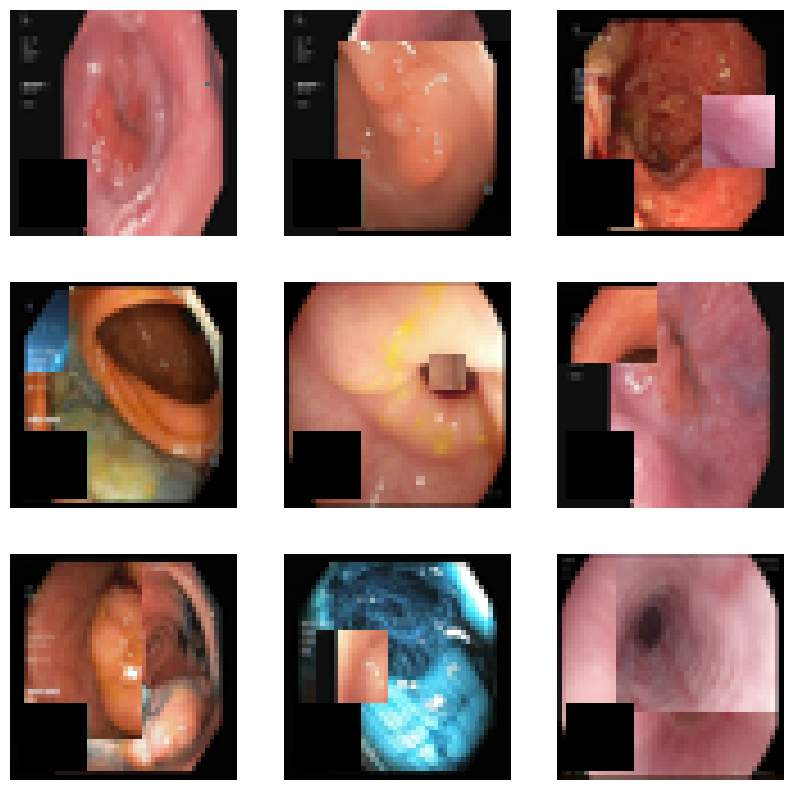

Epoch 1/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 31s 278ms/step - accuracy: 0.4178 - loss: 1.7143 - val_accuracy: 0.1794 - val_loss: 2.1967
Epoch 2/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 269ms/step - accuracy: 0.5752 - loss: 1.2321 - val_accuracy: 0.2529 - val_loss: 1.9445
Epoch 3/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 249ms/step - accuracy: 0.6000 - loss: 1.1816 - val_accuracy: 0.4088 - val_loss: 1.3275
Epoch 4/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 255ms/step - accuracy: 0.6194 - loss: 1.1414 - val_accuracy: 0.6132 - val_loss: 0.9191
Epoch 5/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 252ms/step - accuracy: 0.6298 - loss: 1.1196 - val_accuracy: 0.6750 - val_loss: 0.7638
Epoch 6/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 243ms/step - accuracy: 0.6614 - loss: 1.0888 - val_accuracy: 0.6919 - val_loss: 0.7449
Epoch 7/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 252ms/step - accuracy: 0.6550 - loss: 1.0762 - val_accuracy: 0.7353 - val_loss: 0.6118
Epoch 8/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 244ms/step - accuracy: 0.6547 - loss: 1.0507 - val_accu

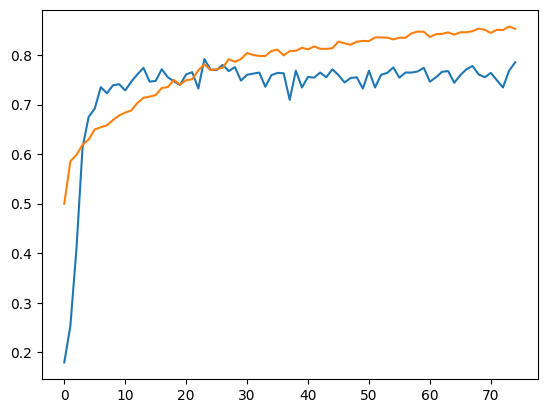

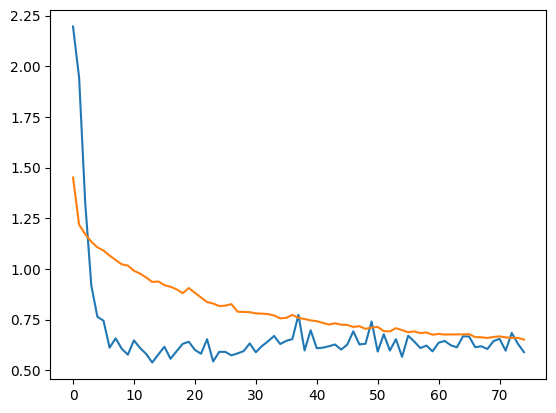

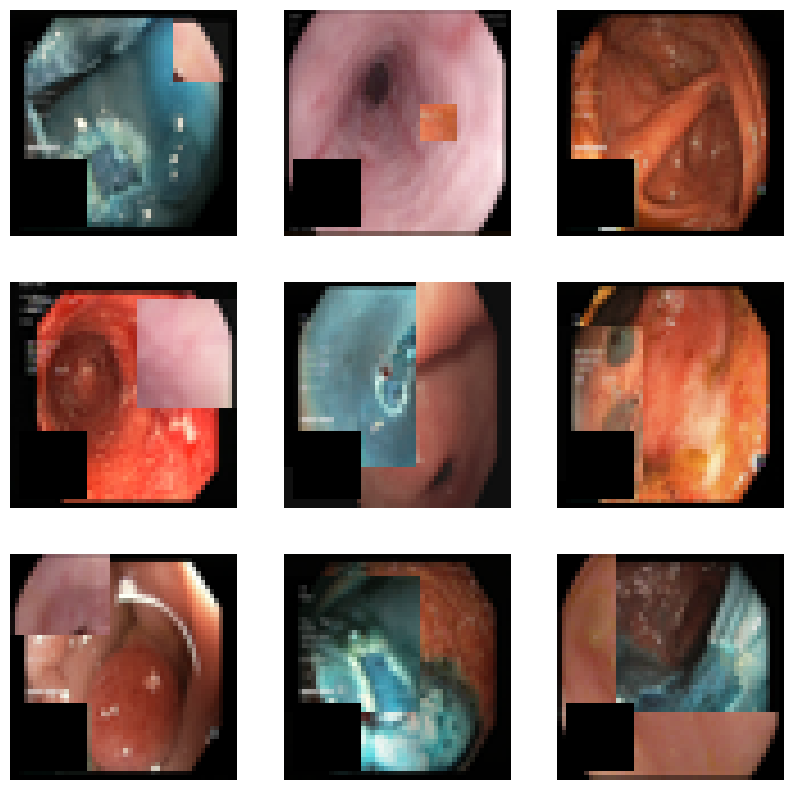

Epoch 1/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 29s 266ms/step - accuracy: 0.3969 - loss: 1.7547 - val_accuracy: 0.2221 - val_loss: 1.7499
Epoch 2/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 252ms/step - accuracy: 0.5550 - loss: 1.2715 - val_accuracy: 0.3654 - val_loss: 1.4592
Epoch 3/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 42s 257ms/step - accuracy: 0.5877 - loss: 1.1885 - val_accuracy: 0.5721 - val_loss: 1.1534
Epoch 4/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 291ms/step - accuracy: 0.6064 - loss: 1.1383 - val_accuracy: 0.6743 - val_loss: 0.8261
Epoch 5/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 260ms/step - accuracy: 0.6182 - loss: 1.1240 - val_accuracy: 0.7235 - val_loss: 0.7095
Epoch 6/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 257ms/step - accuracy: 0.6580 - loss: 1.0889 - val_accuracy: 0.7103 - val_loss: 0.6773
Epoch 7/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 254ms/step - accuracy: 0.6510 - loss: 1.0708 - val_accuracy: 0.7228 - val_loss: 0.6635
Epoch 8/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 258ms/step - accuracy: 0.6748 - loss: 1.0363 - val_accu

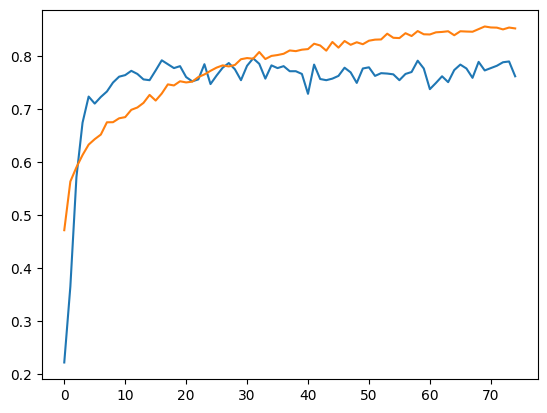

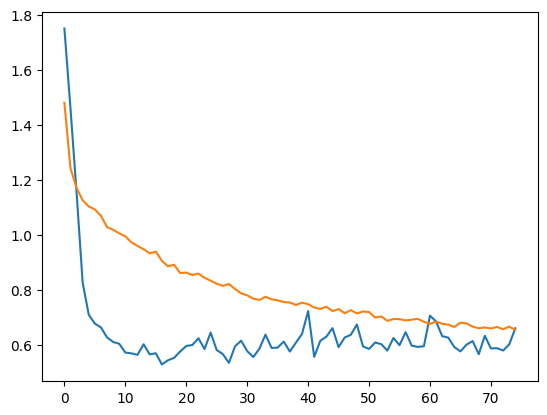

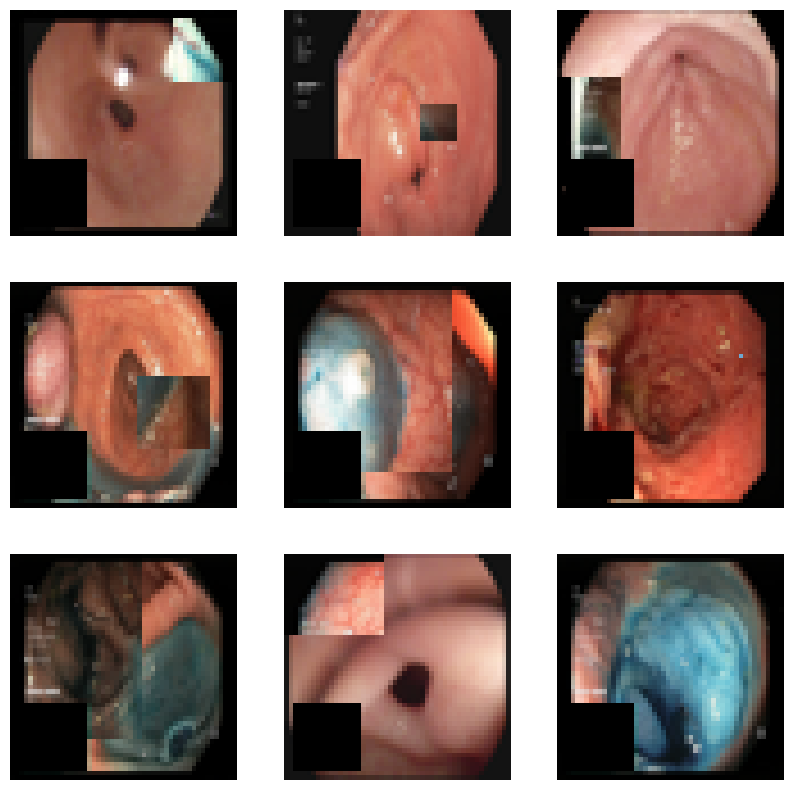

Epoch 1/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 28s 248ms/step - accuracy: 0.4128 - loss: 1.7419 - val_accuracy: 0.2654 - val_loss: 1.7738
Epoch 2/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 250ms/step - accuracy: 0.5781 - loss: 1.2300 - val_accuracy: 0.3809 - val_loss: 1.5246
Epoch 3/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.6101 - loss: 1.1891 - val_accuracy: 0.3772 - val_loss: 1.5831
Epoch 4/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 252ms/step - accuracy: 0.6239 - loss: 1.1588 - val_accuracy: 0.6353 - val_loss: 0.8966
Epoch 5/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 241ms/step - accuracy: 0.6411 - loss: 1.1134 - val_accuracy: 0.6640 - val_loss: 0.7691
Epoch 6/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 239ms/step - accuracy: 0.6449 - loss: 1.0992 - val_accuracy: 0.7213 - val_loss: 0.6794
Epoch 7/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 243ms/step - accuracy: 0.6654 - loss: 1.0597 - val_accuracy: 0.7059 - val_loss: 0.7001
Epoch 8/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 244ms/step - accuracy: 0.6645 - loss: 1.0390 - val_accu

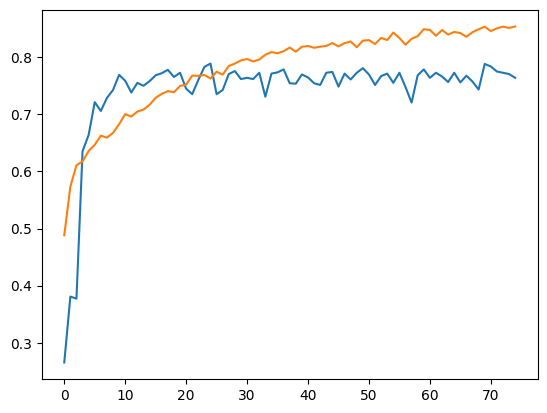

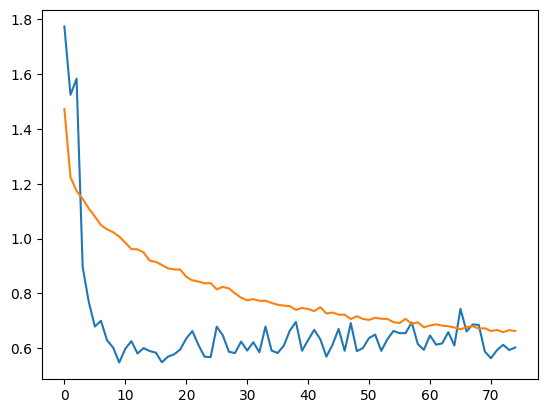

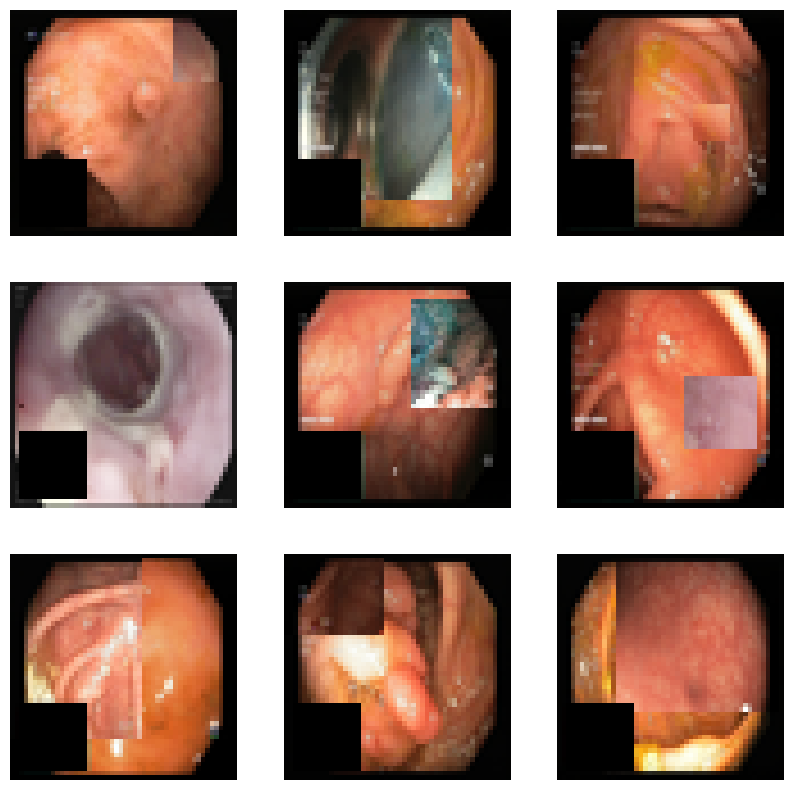

Epoch 1/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 29s 256ms/step - accuracy: 0.4062 - loss: 1.7362 - val_accuracy: 0.3235 - val_loss: 1.8085
Epoch 2/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 251ms/step - accuracy: 0.5705 - loss: 1.2476 - val_accuracy: 0.4118 - val_loss: 1.5782
Epoch 3/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 250ms/step - accuracy: 0.5994 - loss: 1.1877 - val_accuracy: 0.4772 - val_loss: 1.2485
Epoch 4/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 247ms/step - accuracy: 0.6301 - loss: 1.1326 - val_accuracy: 0.5728 - val_loss: 1.1503
Epoch 5/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 247ms/step - accuracy: 0.6217 - loss: 1.1537 - val_accuracy: 0.6559 - val_loss: 0.8132
Epoch 6/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 240ms/step - accuracy: 0.6548 - loss: 1.0854 - val_accuracy: 0.6875 - val_loss: 0.7714
Epoch 7/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.6582 - loss: 1.0625 - val_accuracy: 0.6904 - val_loss: 0.7024
Epoch 8/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 243ms/step - accuracy: 0.6625 - loss: 1.0466 - val_accu

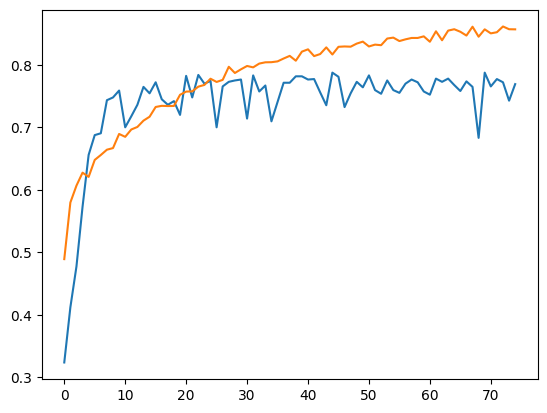

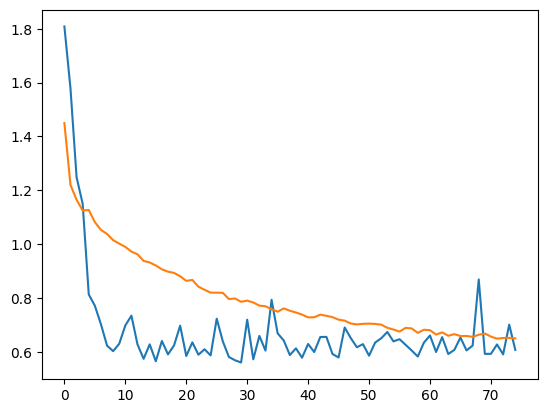

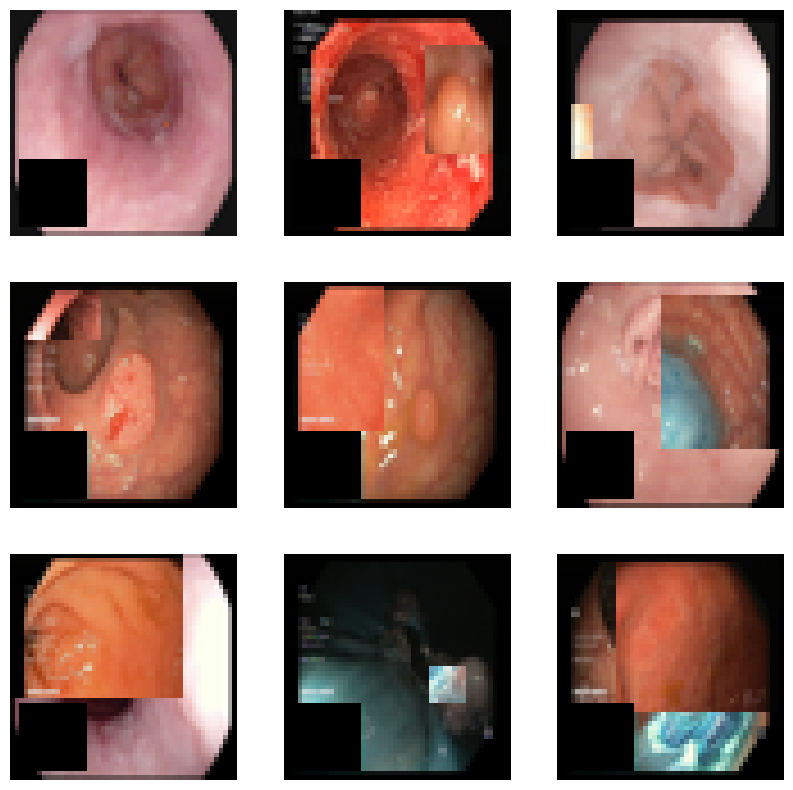

Epoch 1/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 44s 310ms/step - accuracy: 0.4299 - loss: 1.6590 - val_accuracy: 0.2500 - val_loss: 1.7190
Epoch 2/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 27s 315ms/step - accuracy: 0.5787 - loss: 1.2189 - val_accuracy: 0.4140 - val_loss: 1.5013
Epoch 3/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 27s 310ms/step - accuracy: 0.5984 - loss: 1.1912 - val_accuracy: 0.4574 - val_loss: 1.2130
Epoch 4/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 26s 304ms/step - accuracy: 0.6213 - loss: 1.1173 - val_accuracy: 0.6022 - val_loss: 1.0118
Epoch 5/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 26s 303ms/step - accuracy: 0.6421 - loss: 1.1057 - val_accuracy: 0.6404 - val_loss: 0.9086
Epoch 6/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 27s 311ms/step - accuracy: 0.6429 - loss: 1.0669 - val_accuracy: 0.7213 - val_loss: 0.7091
Epoch 7/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 27s 305ms/step - accuracy: 0.6612 - loss: 1.0514 - val_accuracy: 0.7228 - val_loss: 0.6641
Epoch 8/75
85/85 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.6718 - loss: 1.0307 - val_accu

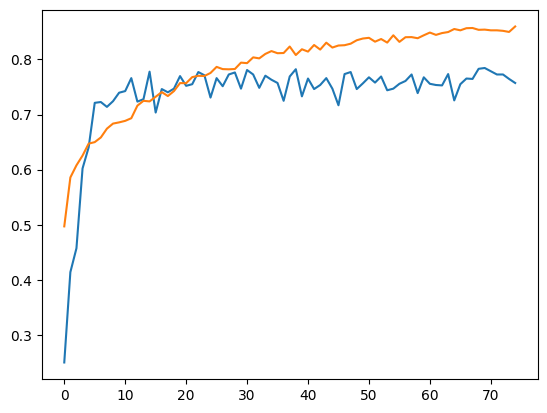

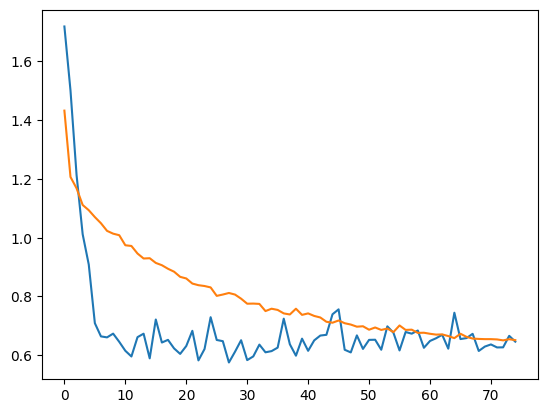

Accuracy:
Mean: 0.7769117712974548, CI: (0.7762216896119667, 0.7776018529829429)
Loss:
Mean: 0.5502585278749466, CI: (0.5488211788117562, 0.5516958769381369)
mean val loss 0.5502585278749466
stdiv val loss 0.01639801128923115
mean val acc 0.7769117712974548
stdiv val acc 0.00787280387132166


In [35]:
filepath = r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\cutmix.keras" #Same logic for the second model
va_lo = []
va_ac = []
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(x_train,y_train)):
    model2 = get_model()
    model2.load_weights('initial_weights.weights.h5')

    model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])



    #filepath = r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\mixup.keras"
    cb1 = keras.callbacks.ModelCheckpoint(filepath,
                                   monitor = "val_loss",
                                   save_best_only = True)
    x_tr, x_va = x_train[train_idx], x_train[val_idx]
    y_tr, y_va = y_train[train_idx], y_train[val_idx]
    x_tr = x_tr.astype("float32")/255.
    x_va = x_va.astype("float32")/255.

    
    train_ds_one = (
    tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
        .shuffle(1024)
        .map(preprocess_image, num_parallel_calls=AUTO)
    )
    train_ds_two = (
        tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
        .shuffle(1024)
        .map(preprocess_image, num_parallel_calls=AUTO)
    )

    train_ds_simple = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))

    val_ds = tf.data.Dataset.from_tensor_slices((x_va, y_va))

# test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

    train_ds_simple = (
        train_ds_simple.map(preprocess_image, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )

# # Combine two shuffled datasets from the same training data.
    train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

# test_ds = (
#     test_ds.map(preprocess_image, num_parallel_calls=AUTO)
#     .batch(BATCH_SIZE)
#     .prefetch(AUTO)
# )

    val_ds = (
        val_ds.map(preprocess_image, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )
    @tf.function
    def cutmix(train_ds_one, train_ds_two):
        (image1, label1), (image2, label2) = train_ds_one, train_ds_two

        alpha = [0.25]
        beta = [0.25]

        # Get a sample from the Beta distribution
        lambda_value = sample_beta_distribution(1, alpha, beta)

        # Define Lambda
        lambda_value = lambda_value[0][0]

        # Get the bounding box offsets, heights and widths
        boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

        # Get a patch from the second image (`image2`)
        crop2 = tf.image.crop_to_bounding_box(
            image2, boundaryy1, boundaryx1, target_h, target_w
        )
        # Pad the `image2` patch (`crop2`) with the same offset
        image2 = tf.image.pad_to_bounding_box(
            crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
        )
        # Get a patch from the first image (`image1`)
        crop1 = tf.image.crop_to_bounding_box(
            image1, boundaryy1, boundaryx1, target_h, target_w
        )
        # Pad the `image1` patch (`crop1`) with the same offset
        img1 = tf.image.pad_to_bounding_box(
            crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
        )

        # Modify the first image by subtracting the patch from `image1`
        # (before applying the `image2` patch)
        image1 = image1 - img1
        # Add the modified `image1` and `image2`  together to get the CutMix image
        image = image1 + image2

        #image1 = tf.cast(image1, tf.float32)
        #image = tf.cast(image, tf.float32)
        target_w = tf.cast(target_w, tf.float32)
        target_h = tf.cast(target_h, tf.float32)


        # Adjust Lambda in accordance to the pixel ration
        lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
        lambda_value = tf.cast(lambda_value, tf.float32)
        label1 = tf.cast(label1, tf.float32)
        label2 = tf.cast(label2, tf.float32)
        # Combine the labels of both images
        label = lambda_value * label1 + (1 - lambda_value) * label2
        return image, label

    
    IMG_SIZE = 50
    #BATCH_SIZE = 32
    train_ds_cmu = (
        train_ds.shuffle(1024)
        .map(cutmix, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )

    # Let's preview 9 samples from the dataset
    image_batch, label_batch = next(iter(train_ds_cmu))
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        #plt.title(class_names[np.argmax(label_batch[i])])
        plt.imshow(image_batch[i])
        plt.axis("off")
    plt.show()

    history2 = model2.fit(train_ds_cmu,epochs = 75, validation_data = val_ds, callbacks = [cb1])
    plt.plot(list(range(75)),history2.history['val_accuracy'])
    plt.plot(list(range(75)),history2.history['accuracy'])
    plt.show()
    plt.plot(list(range(75)),history2.history['val_loss'])
    plt.plot(list(range(75)),history2.history['loss'])
    plt.show()
    cutmix_model = keras.models.load_model(r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\cutmix.keras")
    nnn = 100
    val_los, val_acc = bootstraping1(val_ds, cutmix_model, nnn)
    va_lo.append(val_los)
    va_ac.append(val_acc)

lolo = list_from_lists(va_lo)
acac = list_from_lists(va_ac)
#print(fold_idx)

accuracy_mean = np.mean(acac)
accuracy_std = np.std(acac)
accuracy_ci = (accuracy_mean - 1.96 * accuracy_std / np.sqrt((fold_idx+1)*nnn), accuracy_mean + 1.96 * accuracy_std / np.sqrt((fold_idx+1)*nnn))

loss_mean = np.mean(lolo)
loss_std = np.std(lolo)
loss_ci = (loss_mean - 1.96 * loss_std / np.sqrt((fold_idx+1)*nnn), loss_mean + 1.96 * loss_std / np.sqrt((fold_idx+1)*nnn))

print("Accuracy:")
print(f"Mean: {accuracy_mean}, CI: {accuracy_ci}")
print("Loss:")
print(f"Mean: {loss_mean}, CI: {loss_ci}")
    
print("mean val loss",np.mean(va_lo))
print("stdiv val loss",np.std(va_lo))
print("mean val acc", np.mean(va_ac))
print("stdiv val acc", np.std(va_ac))


In [36]:
cutmix_model = keras.models.load_model(r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\cutmix.keras")
cutmix_model.evaluate(test_ds)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7748 - loss: 0.5690


[0.5772876143455505, 0.7683333158493042]

In [54]:
enc.inverse_transform(Y_test)

array([['normal-pylorus'],
       ['ulcerative-colitis'],
       ['normal-cecum'],
       ...,
       ['esophagitis'],
       ['dyed-lifted-polyps'],
       ['polyps']], dtype=object)

CutMix creates images that represent two classes and therefore the class label of a generated image will be a vector of [a, b] where a+b=1 and a,b!=0. That's kind of penalising the loss function and it results in higher training loss (significantly refreshes the weights). Therefore, a deeper model will be used. 

3 Convolution Layers with CutMix -> Accuracy: 81.41%

In [64]:
def get_model1():
    model1 = models.Sequential()
    model1.add(layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_uniform',input_shape=(50,50,3),data_format = 'channels_last',padding='same'))
    model1.add(layers.BatchNormalization())
    model1.add(layers.MaxPooling2D((2,2)))

    model1.add(layers.Conv2D(256,(2,2),activation='relu',kernel_initializer='he_uniform',data_format = 'channels_last',padding='same'))
    model1.add(layers.BatchNormalization())
    model1.add(layers.MaxPooling2D((2,2)))

    model1.add(layers.Conv2D(128,(2,2),activation='relu',kernel_initializer='he_uniform',data_format = 'channels_last',padding='same'))
    model1.add(layers.BatchNormalization())
    model1.add(layers.MaxPooling2D((2,2)))
    
    model1.add(layers.Flatten())
    model1.add(layers.Dense(256,activation='relu'))
    model1.add(layers.Dropout(0.1))
    model1.add(layers.Dense(512,activation='relu'))
    model1.add(layers.Dropout(0.1))
    model1.add(layers.Dense(1024,activation='relu'))

    #model1.add(layers.Dense(16,activation='relu'))

    model1.add(layers.Dense(8,activation='softmax'))
    return model1

mm = get_model1().summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_47 (Conv2D)              │ (None, 50, 50, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 25, 25, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 25, 25, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 12, 12, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,113,160 (8.06 MB)

 Trainable params: 2,112,136 (8.06 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
filepath = r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\cutmix1.keras" #Same logic for the second model
va_lo = []
va_ac = []
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(x_train,y_train)):
    model2 = get_model1()
    #model2.load_weights('initial_weights.weights.h5')

    model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])



    #filepath = r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\mixup.keras"
    cb1 = keras.callbacks.ModelCheckpoint(filepath,
                                   monitor = "val_accuracy",
                                   save_best_only = True)
    x_tr, x_va = x_train[train_idx], x_train[val_idx]
    y_tr, y_va = y_train[train_idx], y_train[val_idx]
    x_tr = x_tr.astype("float32")/255.
    x_va = x_va.astype("float32")/255.

    
    train_ds_one = (
    tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
        .shuffle(1024)
        .map(preprocess_image, num_parallel_calls=AUTO)
    )
    train_ds_two = (
        tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
        .shuffle(1024)
        .map(preprocess_image, num_parallel_calls=AUTO)
    )

    train_ds_simple = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))

    val_ds = tf.data.Dataset.from_tensor_slices((x_va, y_va))

# test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

    train_ds_simple = (
        train_ds_simple.map(preprocess_image, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )

# # Combine two shuffled datasets from the same training data.
    train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

    val_ds = (
        val_ds.map(preprocess_image, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )
    @tf.function
    def cutmix(train_ds_one, train_ds_two):
        (image1, label1), (image2, label2) = train_ds_one, train_ds_two

        alpha = [0.25]
        beta = [0.25]

        # Get a sample from the Beta distribution
        lambda_value = sample_beta_distribution(1, alpha, beta)

        # Define Lambda
        lambda_value = lambda_value[0][0]

        # Get the bounding box offsets, heights and widths
        boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

        # Get a patch from the second image (`image2`)
        crop2 = tf.image.crop_to_bounding_box(
            image2, boundaryy1, boundaryx1, target_h, target_w
        )
        # Pad the `image2` patch (`crop2`) with the same offset
        image2 = tf.image.pad_to_bounding_box(
            crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
        )
        # Get a patch from the first image (`image1`)
        crop1 = tf.image.crop_to_bounding_box(
            image1, boundaryy1, boundaryx1, target_h, target_w
        )
        # Pad the `image1` patch (`crop1`) with the same offset
        img1 = tf.image.pad_to_bounding_box(
            crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
        )

        # Modify the first image by subtracting the patch from `image1`
        # (before applying the `image2` patch)
        image1 = image1 - img1
        # Add the modified `image1` and `image2`  together to get the CutMix image
        image = image1 + image2

        target_w = tf.cast(target_w, tf.float32)
        target_h = tf.cast(target_h, tf.float32)


        # Adjust Lambda in accordance to the pixel ration
        lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
        lambda_value = tf.cast(lambda_value, tf.float32)
        label1 = tf.cast(label1, tf.float32)
        label2 = tf.cast(label2, tf.float32)
        # Combine the labels of both images
        label = lambda_value * label1 + (1 - lambda_value) * label2
        return image, label

    
    IMG_SIZE = 50
    #BATCH_SIZE = 32
    train_ds_cmu = (
        train_ds.shuffle(1024)
        .map(cutmix, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )

    # Let's preview 9 samples from the dataset
    image_batch, label_batch = next(iter(train_ds_cmu))
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i])
        plt.axis("off")
    plt.show()

    history2 = model2.fit(train_ds_cmu,epochs = 300, validation_data = val_ds, callbacks = [cb1])
    plt.plot(list(range(300)),history2.history['val_accuracy'])
    plt.plot(list(range(300)),history2.history['accuracy'])
    plt.show()
    plt.plot(list(range(300)),history2.history['val_loss'])
    plt.plot(list(range(300)),history2.history['loss'])
    plt.show()
    cutmix_model = keras.models.load_model(r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\cutmix1.keras")
    nnn = 8000
    val_los, val_acc = bootstraping1(val_ds, cutmix_model, nnn)
    va_lo.append(val_los)
    va_ac.append(val_acc)
    break

lolo = list_from_lists(va_lo)
acac = list_from_lists(va_ac)

accuracy_mean = np.mean(acac)
accuracy_std = np.std(acac)
accuracy_ci = (accuracy_mean - 1.96 * accuracy_std / np.sqrt((fold_idx+1)*nnn), accuracy_mean + 1.96 * accuracy_std / np.sqrt((fold_idx+1)*nnn))

loss_mean = np.mean(lolo)
loss_std = np.std(lolo)
loss_ci = (loss_mean - 1.96 * loss_std / np.sqrt((fold_idx+1)*nnn), loss_mean + 1.96 * loss_std / np.sqrt((fold_idx+1)*nnn))

print("Accuracy:")
print(f"Mean: {accuracy_mean}, CI: {accuracy_ci}")
print("Loss:")
print(f"Mean: {loss_mean}, CI: {loss_ci}")
    
print("mean val loss",np.mean(va_lo))
print("stdiv val loss",np.std(va_lo))
print("mean val acc", np.mean(va_ac))
print("stdiv val acc", np.std(va_ac))


In [69]:
cutmix_model.evaluate(x_va,y_va)

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.8275 - loss: 0.4538


[0.4646366834640503, 0.8301470875740051]

Confusion Matrix for the last (best) model on the test set.

38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step


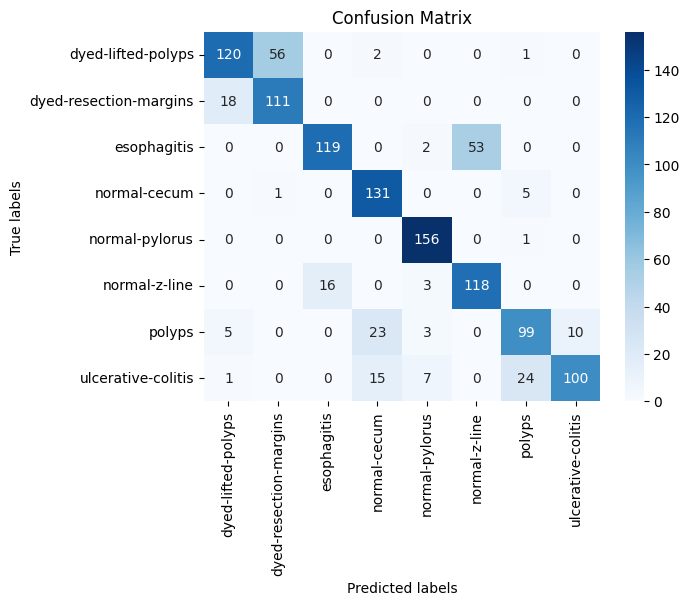

In [31]:
cutmix_model = keras.models.load_model(r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\cutmix1.keras")
from sklearn.metrics import confusion_matrix
import seaborn as sns
prediccs = np.argmax(cutmix_model.predict(x_test),axis=1)
actual = np.argmax(y_test,axis=1)
cf = confusion_matrix(actual,prediccs)
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(enc.inverse_transform(prediccs.reshape(1200,1))), yticklabels=np.unique(enc.inverse_transform(Y_test)))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()